#Introduction


---


Welcome to join us on final project from Spring 2022.

In this notebook, our main analysis topic is Indego bike, which is a share bike public service in Philadelphia. (Hope you will be interested in trying it out after diving into our analysis. We are interested in studying the patterns of ride trips and how we can predict the trip duration of each ride. To enrich our features, we join the Indego trip data with historical weather data from [OpenWeather](https://openweathermap.org/).

We will walk you through our analysis by downloading and importing data, wrangling with data, conducting EDA, extracting features and building predictive models and time series models. Please wisely use the table of contents to scroll to whereever you like. 

Apart from that, we also made a ArcGIS storymap to illustrate Indego trip patterns via maps. Instead of doing maps with Python, ArcGIS is a powerful map-making software as a supplement to our analysis. Please feel free to browse our awesome immersive map through [here](https://storymaps.arcgis.com/stories/5738aa98018947ad801945f131254957).

Let's get started!



> By Yingtong Zhong, Yujing Zhang, Spring 2022



#Save data on drive


---

Since the weather data can not be downloaded from website or server directly, in order to run successfully, please save the follow files to your google drive so that you can read the weather data. 

*   Please kindly clik on this [link](https://drive.google.com/drive/folders/1sGHjgm6PesJKUED0y5x0A21MhLw11II-?usp=sharing) to google drive
*   Right click "data" at the top,  "Add ShortCut to Drive" ->"My drive"
*   The "data" folder can be deleted after you run the notebook










# Libraries Jargon

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import necessary packages
import requests,bs4
import urllib.request
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from pandas.plotting import autocorrelation_plot
from matplotlib import ticker
from sklearn.preprocessing import LabelEncoder
from zipfile import ZipFile
import zipfile

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
###   The funtions below are to unify and optimize visualizations ###

def plot_conf(ax, xlbl='', ylbl='', t='', back_color='#ffffff',
              text_color='#545454', grid_color='#e9e9e9', 
              tick_color='', ticklbl_size=13, lbl_size=13, tsize=15,lang='en'):

    # set the figsize
    #plt.figure(figsize=(13,8))
    # changing the background color of the plot
    ax.set_facecolor(back_color)

    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor=text_color, color=back_color)
    if tick_color != '':
        ax.tick_params(axis='both', color=tick_color)
    ax.tick_params(axis='both', which='major', labelsize=ticklbl_size)

    # adding a grid and specifying its color
    ax.grid(True, color=grid_color)

    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)

    # hiding axes
    #ax.spines['bottom'].set_color(back_color)
    ax.spines['top'].set_color(back_color) 
    ax.spines['right'].set_color(back_color)
    ax.spines['left'].set_color(back_color)

    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=tsize, color='#545454', pad=16, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=8, fontsize=lbl_size, color='#545454', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#545454', labelpad=8, fontsize=lbl_size, fontstyle='italic');

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# Indego color theme
hex_palette = ["#3880C5", "#A2D543"]
sns.set_palette(palette=hex_palette)

In [ ]:
pd.set_option('max_columns', None)

# Data Preprocessing

## Retrieve Data

### Download Indego trip data

Firstly we used beautifulsoup to crawl the zip file on [Indego website](https://www.rideindego.com/about/data/) and then we download and save the trip files by quarter. We will download 6 years data from 2016-2020. However, we will tailor which year to use based on our analysis and computation capacity.


---

The data will be downloaded from the websited directly and unzipped using our UDFs

In [ ]:
! pip install beautifulsoup4

In [ ]:
# self defined function to download Indego Data

def download_IndegoData(year):
  hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
  url = "https://www.rideindego.com/about/data/"
  req = urllib.request.Request(url,headers=hdr)
  response = urllib.request.urlopen(req)
  soup = bs4.BeautifulSoup(response)
  for link in soup.findAll('a',href=re.compile(year)):
          print(link['href'])
  for link in soup.findAll('a',href=re.compile(year)):
    href = link.get("href")
    remoteZip = urllib.request.urlopen(urllib.request.Request(href,headers=hdr))
    file_name = href.rpartition('/')[-1]
    local_file = open(file_name, 'wb')
    local_file.write(remoteZip.read())
    local_file.close()

In [ ]:
# self defined function to unzip Indego Data

def unzip_data():
  path = '/content/'
  extension = ".zip"
  for item in os.listdir(path): # loop through items in dir
      if item.endswith(extension): # check for ".zip" extension
          file_name = os.path.abspath(item) # get full path of files
          zip_ref = zipfile.ZipFile(file_name) # create zipfile object
          zip_ref.extractall(path) # extract file to dir
          zip_ref.close() # close file
          os.remove(file_name) # delete zipped file

In [ ]:
download_IndegoData("2021-q")
download_IndegoData("2020-q")
download_IndegoData("2019-q")
download_IndegoData("2018-q")
download_IndegoData("2017-q")
download_IndegoData("_2017")
download_IndegoData("_2016")

https://u626n26h74f16ig1p3pt0f2g-wpengine.netdna-ssl.com/wp-content/uploads/2022/01/indego-trips-2021-q4.zip
https://u626n26h74f16ig1p3pt0f2g-wpengine.netdna-ssl.com/wp-content/uploads/2021/10/indego-trips-2021-q3.zip
https://u626n26h74f16ig1p3pt0f2g-wpengine.netdna-ssl.com/wp-content/uploads/2021/07/indego-trips-2021-q2.zip
https://u626n26h74f16ig1p3pt0f2g-wpengine.netdna-ssl.com/wp-content/uploads/2021/04/indego-trips-2021-q1.zip
https://u626n26h74f16ig1p3pt0f2g-wpengine.netdna-ssl.com/wp-content/uploads/2021/01/indego-trips-2020-q4.zip
https://u626n26h74f16ig1p3pt0f2g-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/indego-trips-2020-q3.zip
https://u626n26h74f16ig1p3pt0f2g-wpengine.netdna-ssl.com/wp-content/uploads/2020/08/indego-trips-2020-q2.zip
https://u626n26h74f16ig1p3pt0f2g-wpengine.netdna-ssl.com/wp-content/uploads/2020/04/indego-trips-2020-q1.csv.zip
https://u626n26h74f16ig1p3pt0f2g-wpengine.netdna-ssl.com/wp-content/uploads/2020/01/indego-trips-2019-q4.csv.zip
https://u62

In [ ]:
unzip_data()

In [ ]:
# rename files
q1_old16 = r'/content/Indego_Trips_2016Q1.csv'
q1_new16 = r'/content/Indego_Trips_2016-q1.csv'
os.rename(q1_old16, q1_new16)

q2_old16 = r'/content/Indego_Trips_2016Q2.csv'
q2_new16 = r'/content/Indego_Trips_2016-q2.csv'
os.rename(q2_old16, q2_new16)

q3_old16 = r'/content/Q3_2016_trips.csv'
q3_new16 = r'/content/Indego_Trips_2016-q3.csv'
os.rename(q3_old16, q3_new16)

q4_old16 = r'/content/Indego_trips_Q4_2016.csv'
q4_new16 = r'/content/Indego_Trips_2016-q4.csv'
os.rename(q4_old16, q4_new16)

q1_old17 = r'/content/indego_gbfs_trips_Q1_2017.csv'
q1_new17 = r'/content/indego-trips-2017-q1.csv'
os.rename(q1_old17, q1_new17)

q2_old17 = r'/content/indego_gbfs_trips_Q2_2017.csv'
q2_new17 = r'/content/indego-trips-2017-q2.csv'
os.rename(q2_old17, q2_new17)

q4_old17 = r'indego-quarter-echo.bicycletransit.com-2018-01-19-9-57 AM.csv'
q4_new17 = r'/content/indego-trips-2017-q4.csv'
os.rename(q4_old17, q4_new17)

### Read station data


---

The below cell will read the station data downloaded directly alongwith the trip data.

In [ ]:
station = pd.read_csv('indego-stations-2021-10-01.csv')
station['Station_ID'] = station['Station_ID'].astype('str')
station.head()

Station_ID                       Station_Name Day of Go_live_date  Status
0       3000                    Virtual Station           4/23/2015  Active
1       3004  Municipal Services Building Plaza           4/23/2015  Active
2       3005                  Welcome Park, NPS           4/23/2015  Active
3       3006                      40th & Spruce           4/23/2015  Active
4       3007             11th & Pine, Kahn Park           4/23/2015  Active

### Read external weather data 


---

You must save/add short cut the "data" folder to your drive so that you can read the weather file. You may also modify the path where you save the "data" folder.

In [ ]:
path = '/content/drive/MyDrive/data/'
weather = pd.read_csv(path+'weatherHourly.csv')
weather.head()

dt                         dt_iso  timezone     city_name  \
0  1420070400  2015-01-01 00:00:00 +0000 UTC    -18000  Philadelphia   
1  1420074000  2015-01-01 01:00:00 +0000 UTC    -18000  Philadelphia   
2  1420077600  2015-01-01 02:00:00 +0000 UTC    -18000  Philadelphia   
3  1420081200  2015-01-01 03:00:00 +0000 UTC    -18000  Philadelphia   
4  1420084800  2015-01-01 04:00:00 +0000 UTC    -18000  Philadelphia   

         lat        lon    temp  visibility  dew_point  feels_like  temp_min  \
0  39.952584 -75.165222  272.49     10000.0     262.40      267.65    271.67   
1  39.952584 -75.165222  271.39     10000.0     262.87      267.01    271.39   
2  39.952584 -75.165222  271.40     10000.0     263.78      267.03    271.39   
3  39.952584 -75.165222  271.99     10000.0     264.56      266.13    271.58   
4  39.952584 -75.165222  271.39     10000.0     264.41      265.63    270.67   

   temp_max  pressure  sea_level  grnd_level  humidity  wind_speed  wind_deg  \
0    272.49      1025        NaN         NaN        42         4.6       220   
1    272.68      1025        NaN         NaN        48         3.6       200   
2    272.67      1025        NaN         NaN        52         3.6       190   
3    271.99      1024        NaN         NaN        53         6.2       220   
4    271.39      1024        NaN         NaN        55         5.7       230   

   wind_gust  rain_1h  rain_3h  snow_1h  snow_3h  clouds_all  weather_id  \
0        NaN      NaN      NaN      NaN      NaN           1         800   
1        NaN      NaN      NaN      NaN      NaN           1         800   
2        NaN      NaN      NaN      NaN      NaN           1         800   
3        NaN      NaN      NaN      NaN      NaN           1         800   
4        NaN      NaN      NaN      NaN      NaN           1         800   

  weather_main weather_description weather_icon  
0        Clear        sky is clear          01n  
1        Clear        sky is clear          01n  
2        Clear        sky is clear          01n  
3        Clear        sky is clear          01n  
4        Clear        sky is clear          01n

In [ ]:
# Clean time format and convert it to EST corresponding to time data in Indego 
import pytz
from datetime import datetime

weather['UTCtime']= weather['dt_iso'].astype(str).str[:-9]
weather['UTCtime'] = pd.to_datetime(weather['UTCtime'],utc=True)
est = pytz.timezone('US/Eastern')
fmt = '%m/%d/%Y %H:%M:%S'
weather['ESTtime'] = weather['UTCtime'].apply(lambda x : x.astimezone(est).strftime(fmt))
weather['ESTtime'] = pd.to_datetime(weather['ESTtime'])

In [ ]:
# Extract keys for merge
weather['ESTtime_date'] = weather['ESTtime'].dt.strftime('%m-%d-%Y')
weather['ESTtime_hour'] = weather['ESTtime'].dt.strftime('%H')

### Clean, merge trip data with weather data


---


*  First of all, we need to read all the trip data and concat them by year since they are saved by quarter
*  Then we need to extract date and hour as keys to join/merge the weather data





In [ ]:
# Prepare dataframe for each year
def read_concat_clean(year):
  year = f"{year}-q"
  filepaths = [f for f in os.listdir(".") if f.endswith('.csv') and year in f]
  df = pd.concat(map(pd.read_csv, filepaths)).reset_index(drop=True)
  return df

In [ ]:
# 2020 data
df_2020 = read_concat_clean(2020)

# 2021 data
df_2021 = read_concat_clean(2021)

# 2019 data
df_2019 = read_concat_clean(2019)

# 2018 data
df_2018 = read_concat_clean(2018)

# 2017 data
df_2017 = read_concat_clean(2017)

# 2016 data
df_2016 = read_concat_clean(2016)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/concat.py:304: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  sort=sort,


In [ ]:
# UDF to clean, extract and merge the data

def clean_df(df):
  # transform to datetime type
  df['start_time'] = pd.to_datetime(df['start_time'])
  df['end_time'] = pd.to_datetime(df['end_time'])

  # add_datetime_features
  df['start_time_date'] = df['start_time'].dt.strftime('%m-%d-%Y')
  df['start_time_year'] = df['start_time'].dt.strftime('%Y')
  df['start_time_month'] = df['start_time'].dt.strftime('%m')
  df['start_time_hour'] = df['start_time'].dt.strftime('%H')
  df['start_time_day'] = df['start_time'].dt.strftime('%d')
  df['start_dayOfWeek'] = df['start_time'].map(lambda x : x.strftime("%w"))
  df['start_dayOfWeek.name'] = df['start_time'].map(lambda x : x.strftime("%A"))
  df['start_dayOfYear'] = df['start_time'].map(lambda x : x.timetuple().tm_yday)
  df['start_weekOfYear.name'] = df['start_time'].map(lambda x : x.strftime("%W"))

  return df

def merge_weather(df,weather):
  # merge trip data with weather data
  df_merge = df.merge(weather,left_on=['start_time_date','start_time_hour'],
                                  right_on = ['ESTtime_date','ESTtime_hour'], how = 'left',indicator = True)
  return df_merge

def get_TimeSeriesDf(df):
  df_pro = df[['duration','start_time','start_time_date','start_time_month']]
  return df_pro

In [ ]:
# clean the trip data
df_2020 = clean_df(df_2020)
df_2021 = clean_df(df_2021)
df_2019 = clean_df(df_2019)
df_2018 = clean_df(df_2018)
df_2017 = clean_df(df_2017)
df_2016 = clean_df(df_2016)

In [ ]:
# merge the cleaned df with weather for just 3 years
df_2020 = merge_weather(df_2020,weather)
df_2021 = merge_weather(df_2021,weather)
df_2019 = merge_weather(df_2019,weather)

In [ ]:
# prepare time series df
pdf_2021 = get_TimeSeriesDf(df_2021)
pdf_2020 = get_TimeSeriesDf(df_2020)
pdf_2019 = get_TimeSeriesDf(df_2019)
pdf_2018 = get_TimeSeriesDf(df_2018)
pdf_2017 = get_TimeSeriesDf(df_2017)
pdf_2016 = get_TimeSeriesDf(df_2016)

#### Memory optimization : downcast object


---

Since the datasets are large, we want to monitor the memory used and possibly optimize the ram by downcasting the types of data taking up the most memory. Firstly we perform a memory check for each type of data. Then we downcast the type of data with most memory usded.

In [ ]:
# memory check 

def memory_usage_per_type(data_frame):
    types = ['float','int','object','datetime64']
    for type in types:
        selected_col=data_frame.select_dtypes(include=[type])
        memory_usage_of_selected_type_b = selected_col.memory_usage(deep=True).sum()
        memory_usage_of_selected_type_mb=memory_usage_of_selected_type_b/1024**2
        print("memory usage for {} columns: {:03.2f} MB".format(type,memory_usage_of_selected_type_mb))

In [ ]:
memory_usage_per_type(df_2020)

memory usage for float columns: 120.48 MB
memory usage for int columns: 80.32 MB
memory usage for object columns: 868.33 MB
memory usage for datetime64 columns: 22.95 MB


**We can see that object type takes up a large memory. Why is that?**

It's because Pandas automatically stores categorical columns as object and it creates a list of pointers to the memory address of each value of the categorical column. So strings are stored in a fragmented way that comsumes more memory and is slower to access



---

**So how are we going to optimize object type?**


*   We can convert the object type to category type as it use integer values under the hood to represent the values in a column rather than the raw values. However, the mapping dictionary is useful in downcasting whenever a column contains a limited set of values.
*   So for columns with low cardinality (the amount of unique values is lower than 50% of the count of these values) and with object datatype, this can be optimized by converting object into category datatype



In [ ]:
def memory_usage(data_frame):
    return data_frame.memory_usage(deep=True).sum()/1024**2

def downcast_object(df):
    print('before the downcast:{:.2f} MB'.format(memory_usage(df)))
    df2 = df.copy()
    for col in df2.columns[df2.dtypes=='object']:
        numbr_of_unique = len(df2[col].unique())
        numbr_total = len(df2[col])
        if numbr_of_unique/numbr_total<0.5:            
            df2[col] = df2[col].astype('category')
    print('after the downcast:{:.2f} MB'.format(memory_usage(df2)))
    print('')
    return df2

In [ ]:
print('df_2019')
ddf_2019 = downcast_object(df_2019)
print('df_2020')
ddf_2020 = downcast_object(df_2020)
print('df_2021')
ddf_2021 = downcast_object(df_2021)

df_2019
before the downcast:1080.82 MB
after the downcast:247.16 MB

df_2020
before the downcast:1081.33 MB
after the downcast:236.47 MB

df_2021
before the downcast:1406.70 MB
after the downcast:306.73 MB



We apply the same idea to downcast the float type data into low-memory type, from float64 to float32

In [ ]:
def downcast_and_compare_memory_consuming_by_type_first(df,type_):
    df2 = df.copy()
    df2[df2.columns[df2.dtypes==type_]] = df2[df2.columns[df2.dtypes==type_]].apply(pd.to_numeric,downcast=type_)
    converted_type = df2.select_dtypes(include=[type_]).apply(pd.to_numeric,downcast=type_)
    memory_before = memory_usage(df)
    memory_after = memory_usage(df2)
    print('before the downcast:{:.2f} MB'.format(memory_before))
    print('after the downcast:{:.2f} MB'.format(memory_after))
    print('')
    return df2

In [ ]:
print('df_2019')
ddf_2019 = downcast_and_compare_memory_consuming_by_type_first(ddf_2019,'float')
print('df_2020')
ddf_2020 = downcast_and_compare_memory_consuming_by_type_first(ddf_2020,'float')
print('df_2021')
ddf_2021 = downcast_and_compare_memory_consuming_by_type_first(ddf_2021,'float')


df_2019
before the downcast:247.16 MB
after the downcast:185.26 MB

df_2020
before the downcast:236.47 MB
after the downcast:179.10 MB

df_2021
before the downcast:306.73 MB
after the downcast:232.24 MB



In [ ]:
# downcast time series data
pdf_2021 = downcast_object(pdf_2021)
pdf_2021 = downcast_and_compare_memory_consuming_by_type_first(pdf_2021,'float')

pdf_2020 = downcast_object(df_2020)
pdf_2020 = downcast_and_compare_memory_consuming_by_type_first(df_2020,'float')

pdf_2019 = downcast_object(pdf_2019)
pdf_2019 = downcast_and_compare_memory_consuming_by_type_first(pdf_2019,'float')

pdf_2018 = downcast_object(pdf_2018)
pdf_2018 = downcast_and_compare_memory_consuming_by_type_first(pdf_2018,'float')

pdf_2017 = downcast_object(pdf_2017)
pdf_2017 = downcast_and_compare_memory_consuming_by_type_first(pdf_2017,'float')

pdf_2016 = downcast_object(pdf_2016)
pdf_2016 = downcast_and_compare_memory_consuming_by_type_first(pdf_2016,'float')

before the downcast:139.67 MB
after the downcast:25.17 MB

before the downcast:25.17 MB
after the downcast:25.17 MB

before the downcast:1081.33 MB
after the downcast:236.47 MB

before the downcast:1081.33 MB
after the downcast:1023.95 MB

before the downcast:110.53 MB
after the downcast:19.93 MB

before the downcast:19.93 MB
after the downcast:19.93 MB

before the downcast:90.98 MB
after the downcast:12.21 MB

before the downcast:12.21 MB
after the downcast:12.21 MB

before the downcast:106.84 MB
after the downcast:14.33 MB

before the downcast:14.33 MB
after the downcast:14.33 MB

before the downcast:88.71 MB
after the downcast:11.90 MB

before the downcast:11.90 MB
after the downcast:11.90 MB



### Create time series dataframe


---

In the Indego dataframe, our data is sotred hourly. But for time series analysis, we only want to keep the average duaration of bike using for each day, not for each hour. So we create the dataframe with average duration of each day form 2016 to 2021. (We chose data from 2016 to 2020 because it is the data of the longest time for which we could retrieve.)

We also need to do some unit conversion on the numbers from 2016 and 2017 before we can generate a time series. Some duration data are recorded in seconds, but we need them to be in minutes to match the rest of our data.

In [ ]:
# change unit of duration from second to minute (2016-2017Q1)
pdf_2016['duration'] = pdf_2016['duration']/60
pdf_2017.loc[pdf_2017.start_time<'2017-04-01','duration'] = pdf_2017.loc[pdf_2017.start_time<'2017-04-01','duration']/60

In [ ]:
# create time series
ddf_6yr = pd.concat([pdf_2016[['start_time_date','duration']],pdf_2017[['start_time_date','duration']],pdf_2018[['start_time_date','duration']],
                     pdf_2019[['start_time_date','duration']],pdf_2020[['start_time_date','duration']],pdf_2021[['start_time_date','duration']]])
ddf_6yr['start_time_date'] = pd.to_datetime(ddf_6yr['start_time_date'])
ddf_6yr = ddf_6yr.sort_values(by='start_time_date').groupby('start_time_date').mean()

In [ ]:
# brief review of time series
ddf_6yr.describe()

duration
count  2190.000000
mean     22.809429
std       8.570488
min      11.000000
25%      17.941101
50%      20.772100
75%      26.161266
max     251.333333

Here we find the max value is extremely large. Is it an outlier? Let's check!

In [ ]:
# check the extreme large value
ddf_6yr[ddf_6yr['duration']>100]


duration
start_time_date            
2016-01-26       251.333333

The value of this day is an outlier, so we decided to drop it

In [ ]:
ddf_6yr = ddf_6yr[ddf_6yr['duration']<100]

# Exploratory Data Analysis

## Indego Trip Data EDA


---

In this section, we will conduct EDA of Indego trip data joined with weather data mainly in 2021 which will be our modeling dataset, but will include data of previous years to make comparison. We will start by doing a data inspection, then we will visualize some patterns analyzed through trip data. After that we will bring in the Indego bike station data to do a preliminary analysis.

To mention that, we will deal with Null values and conduct a correlation analysis in feature engineering since only those main variables will be conducted EDA here.

### Data inspection


*  Data size conclusion
1. There are 976350 entries in the 2021 indego trip dataframe. 
2. There are 751991 entries in the 2020 indego trip dataframe.   
3. There are 772663 entries in the 2019 indego trip dataframe. 

In [ ]:
print(f'2021:{len(ddf_2021)}')
print(f'2020:{len(ddf_2020)}')
print(f'2019:{len(ddf_2019)}')

2021:976350
2020:751991
2019:772663


*  Columns of 2021 indego data

We can see that the trip variables we want to conduct EDA are all non-null values. And we will not use all the columns for our analysis, so we will save the process of dealing with other missing values when it comes to building models. 

In [ ]:
# display the column information of 2021 indego df
ddf_2021.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976350 entries, 0 to 976349
Data columns (total 57 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   trip_id                976350 non-null  int64              
 1   duration               976350 non-null  int64              
 2   start_time             976350 non-null  datetime64[ns]     
 3   end_time               976350 non-null  datetime64[ns]     
 4   start_station          976350 non-null  int64              
 5   start_lat              976315 non-null  float32            
 6   start_lon              976315 non-null  float32            
 7   end_station            976350 non-null  int64              
 8   end_lat                960406 non-null  float32            
 9   end_lon                960406 non-null  float32            
 10  bike_id                976350 non-null  category           
 11  plan_duration          976350 non-null 

In [ ]:
# list of columns
import cmd
cli = cmd.Cmd()
cli.columnize(list(ddf_2021.columns), displaywidth=80)

trip_id              start_time_date        temp        snow_1h            
duration             start_time_year        visibility  snow_3h            
start_time           start_time_month       dew_point   clouds_all         
end_time             start_time_hour        feels_like  weather_id         
start_station        start_time_day         temp_min    weather_main       
start_lat            start_dayOfWeek        temp_max    weather_description
start_lon            start_dayOfWeek.name   pressure    weather_icon       
end_station          start_dayOfYear        sea_level   UTCtime            
end_lat              start_weekOfYear.name  grnd_level  ESTtime            
end_lon              dt                     humidity    ESTtime_date       
bike_id              dt_iso                 wind_speed  ESTtime_hour       
plan_duration        timezone               wind_deg    _merge             
trip_route_category  city_name              wind_gust 
passholder_type      lat         

In [ ]:
ddf_2021 = ddf_2021.sort_values(by='start_time').reset_index(drop=True)

In [ ]:
# mean of 2021 trip duration
ddf_2021.duration.mean()

18.891746812106316

### Distribution of trip duration
---
**Motivation:** How long does each trip take normally for a rider?

**Insight:** In 2021 Indego trip data, each entry of data indicates a ride trip by a user. Plotting a histogram of distribution of trip duration of 976350 entries, we can see a fair normal distribution with mean around 20 minutes in usage.

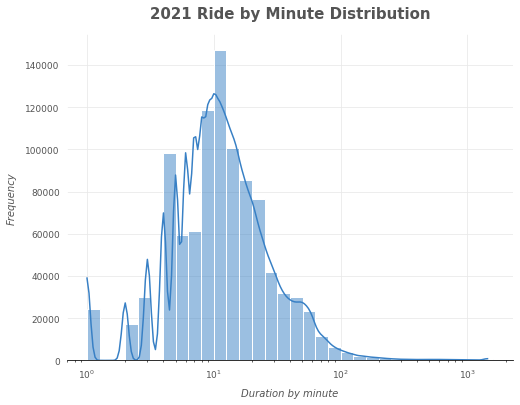

In [ ]:
# Histgram of duration distribution
# set the figure and edgecolor for bar
plt.figure(figsize=(8,6))
plt.rcParams['patch.edgecolor'] = 'white' 

# set color theme
hex_palette = ["#3880C5", "#A2D543"]
sns.set_palette(palette=hex_palette)

ax = sns.histplot(data=ddf_2021, x="duration",log_scale=True,binwidth=0.1,kde=True,color='C2')
plot_conf(ax,xlbl= 'Duration by minute',ylbl='Frequency', t='2021 Ride by Minute Distribution', ticklbl_size=9, lbl_size=10)
#plt.savefig("2021 Ride by Minute Distribution.png")

### Trip duration breakdown by bike type
---
**Motivation:** Indego provides standard and electric bikes for riders. It would be interesting to see how they differentiate in duration patterns.

**Insight:** It is obviously that standard bikes are still the popular choice, but the duration patterns have no major difference between standard and electric bikes. Below 30-minute-trip takes up nearly 90% of the trips in 2021 for both electric and standard bikes.


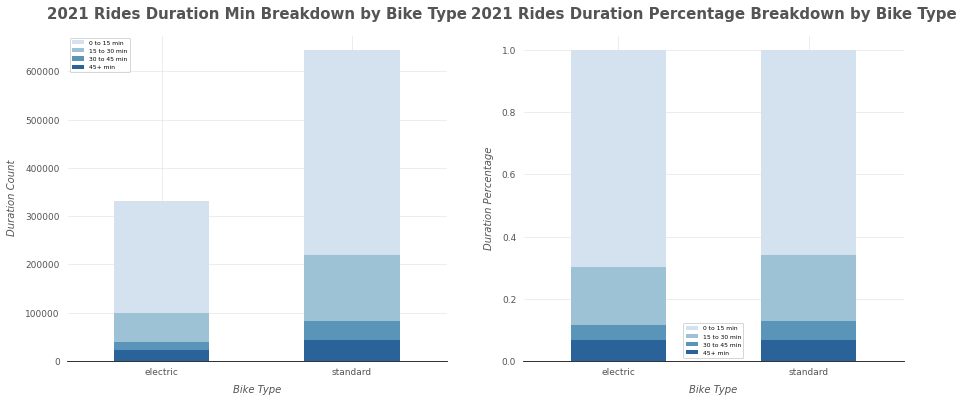

In [ ]:
# mapping duration range in to bins 
bins = [0, 15, 30, 45, np.inf]
names = ['0 to 15 min', '15 to 30 min', '30 to 45 min', '45+ min']

ddf_2021['DurationRange'] = pd.cut(ddf_2021['duration'], bins, labels=names)
DurationRangePer = pd.crosstab(ddf_2021['bike_type'], ddf_2021['DurationRange'],normalize='index')
DurationRangeAct = pd.crosstab(ddf_2021['bike_type'], ddf_2021['DurationRange'])
######################### Plot #####################################
f, axes = plt.subplots(1,2, figsize=(15, 6))

sns.barplot(data=DurationRangeAct.iloc[:,::-1].cumsum(axis=1).stack().reset_index(name='Percentage'),
            x='bike_type', y='Percentage', hue='DurationRange',
            palette = 'Blues',
            dodge=False,ax = axes[0])

sns.barplot(data=DurationRangePer.iloc[:,::-1].cumsum(axis=1).stack().reset_index(name='Percentage'),
            x='bike_type', y='Percentage', hue='DurationRange',
            palette = 'Blues',
            dodge=False,ax = axes[1])

axes[0].legend(fontsize=6,loc = 'best')
axes[1].legend(fontsize=6,loc = 'best')

plot_conf(axes[0],xlbl= 'Bike Type',ylbl='Duration Count', t='2021 Rides Duration Min Breakdown by Bike Type', ticklbl_size=9, lbl_size=10)
change_width(axes[0], 0.5)

plot_conf(axes[1],xlbl= 'Bike Type',ylbl='Duration Percentage', t='2021 Rides Duration Percentage Breakdown by Bike Type', ticklbl_size=9, lbl_size=10)
change_width(axes[1], 0.5)

#plt.savefig("2021 Rides Duration Min and per Breakdown by Bike Type")

### Ride count breakdown by bike type over month 
---
**Motivation:** It's assumed that people tend to ride outdoors when the weather is warm. Let's see if we can inspect any cyclical behavior for rides.

**Insight:** 
*   Group by years in 2021, we can see the ride counts do present a seasonal pattern. Rides are low in bottom in winter and they gradually increase through Spring to Fall, at which reach peak, then again decrease as weather gets colder. Those patterns are the same for electric and standard bikes as well. Noticeably there was a unusual surge at September, that's mainly due to a [CollegeFest promotion](https://campusphilly.org/activities/indego-philly-bike-share/) of Indego bike for campus students.
*   We did the same analysis for the previous years in 2019 and 2020. They all show cyclical behavior throughout the seasons. It is also interesting to see that the number of rides increase from 2019 to 2021 overall.



In [ ]:
ddf_2021.head(1)

trip_id  duration          start_time            end_time  start_station  \
0  365184634        15 2021-01-01 00:05:00 2021-01-01 00:20:00           3125   

   start_lat  start_lon  end_station    end_lat    end_lon bike_id  \
0  39.943909 -75.167351         3157  39.925449 -75.159538   14542   

   plan_duration trip_route_category passholder_type bike_type  \
0             30             One Way        Indego30  standard   

  start_time_date start_time_year start_time_month start_time_hour  \
0      01-01-2021            2021               01              00   

  start_time_day start_dayOfWeek start_dayOfWeek.name  start_dayOfYear  \
0             01               5               Friday                1   

  start_weekOfYear.name          dt                         dt_iso  timezone  \
0                    00  1609477200  2021-01-01 05:00:00 +0000 UTC    -18000   

      city_name        lat        lon       temp  visibility   dew_point  \
0  Philadelphia  39.952583 -75.165222  275.01001     10000.0  269.959991   

   feels_like    temp_min  temp_max  pressure  sea_level  grnd_level  \
0   275.01001  273.130005     276.0      1030        NaN         NaN   

   humidity  wind_speed  wind_deg  wind_gust  rain_1h  rain_3h  snow_1h  \
0        67        0.89       306       3.13      NaN      NaN      NaN   

   snow_3h  clouds_all  weather_id weather_main weather_description  \
0      NaN          20         801       Clouds          few clouds   

  weather_icon                   UTCtime    ESTtime ESTtime_date ESTtime_hour  \
0          02n 2021-01-01 05:00:00+00:00 2021-01-01   01-01-2021           00   

  _merge DurationRange  
0   both   0 to 15 min

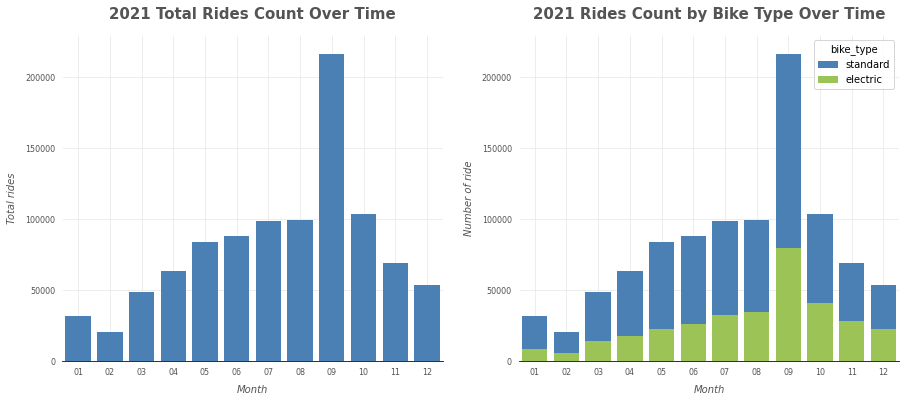

In [ ]:
# calculate the distribution of `bike type` per `month`
distribution = pd.crosstab(ddf_2021['start_time_month'], ddf_2021['bike_type'])

# set color theme
hex_palette = ["#3880C5", "#A2D543"]
sns.set_palette(palette=hex_palette)

# plot two subplots of ride count over month and by type side by side
f, axes = plt.subplots(1,2, figsize=(15, 6))

sns.countplot(data=ddf_2021, x="start_time_month",color='C2',ax =axes[0])
sns.barplot(data=distribution.cumsum(axis=1).stack().reset_index(name='Count'),
            x='start_time_month', y='Count', hue='bike_type',
            hue_order = distribution.columns[::-1],   # reverse hue order so that the taller bars got plotted first
            palette = hex_palette,
            dodge=False, ax = axes[1])
axes[1].set_ylim([0, 230000])
axes[0].set_ylim([0, 230000])
# visualization
plot_conf(axes[0],xlbl= 'Month',ylbl='Total rides', t='2021 Total Rides Count Over Time', ticklbl_size=8, lbl_size=10)
plot_conf(axes[1],xlbl= 'Month',ylbl='Number of ride', t='2021 Rides Count by Bike Type Over Time', ticklbl_size=8, lbl_size=10)
#plt.savefig("2021 Rides Count by Bike Type Over Time")

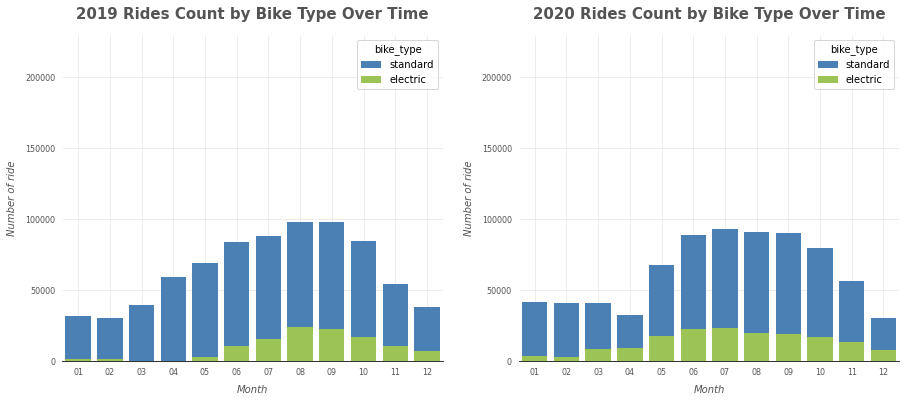

In [ ]:
# calculate the distribution of `bike type` per `month`
distribution19 = pd.crosstab(ddf_2019['start_time_month'], ddf_2019['bike_type'])
distribution20 = pd.crosstab(ddf_2020['start_time_month'], ddf_2020['bike_type'])

# set color theme
hex_palette = ["#3880C5", "#A2D543"]
sns.set_palette(palette=hex_palette)

# plot two subplots of ride count over month and by type side by side
f, axes = plt.subplots(1,2, figsize=(15, 6))

sns.barplot(data=distribution19.cumsum(axis=1).stack().reset_index(name='Count'),
            x='start_time_month', y='Count', hue='bike_type',
            hue_order = distribution19.columns[::-1],   # reverse hue order so that the taller bars got plotted first
            palette = hex_palette,
            dodge=False, ax = axes[0])
sns.barplot(data=distribution20.cumsum(axis=1).stack().reset_index(name='Count'),
            x='start_time_month', y='Count', hue='bike_type',
            hue_order = distribution20.columns[::-1],   # reverse hue order so that the taller bars got plotted first
            palette = hex_palette,
            dodge=False, ax = axes[1])
axes[1].set_ylim([0, 230000])
axes[0].set_ylim([0, 230000])
# visualization
plot_conf(axes[0],xlbl= 'Month',ylbl='Number of ride', t='2019 Rides Count by Bike Type Over Time', ticklbl_size=8, lbl_size=10)
plot_conf(axes[1],xlbl= 'Month',ylbl='Number of ride', t='2020 Rides Count by Bike Type Over Time', ticklbl_size=8, lbl_size=10)
#plt.savefig("2019_2020 Rides Count by Bike Type Over Time")

### Station analysis
---
**Motivation:** Finally we might be curious how what are the top stations riders start their trips and end their trips.

**Insight:** 
*   Merged with station data, we joined them with the trip data and groupby station to get the count of rides of each station in 2021. We can see that top 10 frequent used start and end stations are quite similar. Based on the names of stations, frequent trips take place in center Philadelphia.
*   We then also draw a net outflow vs. net inflow of by getting the difference of outbound and inbound trips per station. It is clearly that demands for outbound trips are higher than inbound trips. That might suggests a shortage of demand for bikes over docks.

Using data of 2021

In [ ]:
# Distribution of start/end stations
start_station = ddf_2021.groupby('start_station').count().sort_values(by='trip_id',ascending=False)[['trip_id']].rename(columns = {'trip_id': 'count'}).reset_index()
end_station = ddf_2021.groupby('end_station').count().sort_values(by='trip_id',ascending=False)[['trip_id']].rename(columns = {'trip_id': 'count'}).reset_index()

start_station['start_station']=start_station['start_station'].astype(str)
end_station['end_station']=end_station['end_station'].astype(str)

# join station name
start_station_name = pd.merge(start_station,station[['Station_ID','Station_Name']],left_on='start_station',right_on='Station_ID',how='left').drop(axis=1,columns=['Station_ID'])
end_station_name = pd.merge(end_station,station[['Station_ID','Station_Name']],left_on='end_station',right_on='Station_ID',how='left').drop(axis=1,columns=['Station_ID'])

In [ ]:
start_station_name.head()

start_station  count     Station_Name
0          3202  17877  16th & Chestnut
1          3010  17859    15th & Spruce
2          3032  16258     23rd & South
3          3208  15997    34th & Spruce
4          3190  15830    17th & Locust

There are four stations without name. Fortunately, they are not the most often used stations, so that we can just ignore them.

In [ ]:
start_station_name[start_station_name['Station_Name'].isna()]

start_station  count Station_Name
167          3257    279          NaN
168          3259    253          NaN
169          3258    212          NaN
170          3261    185          NaN

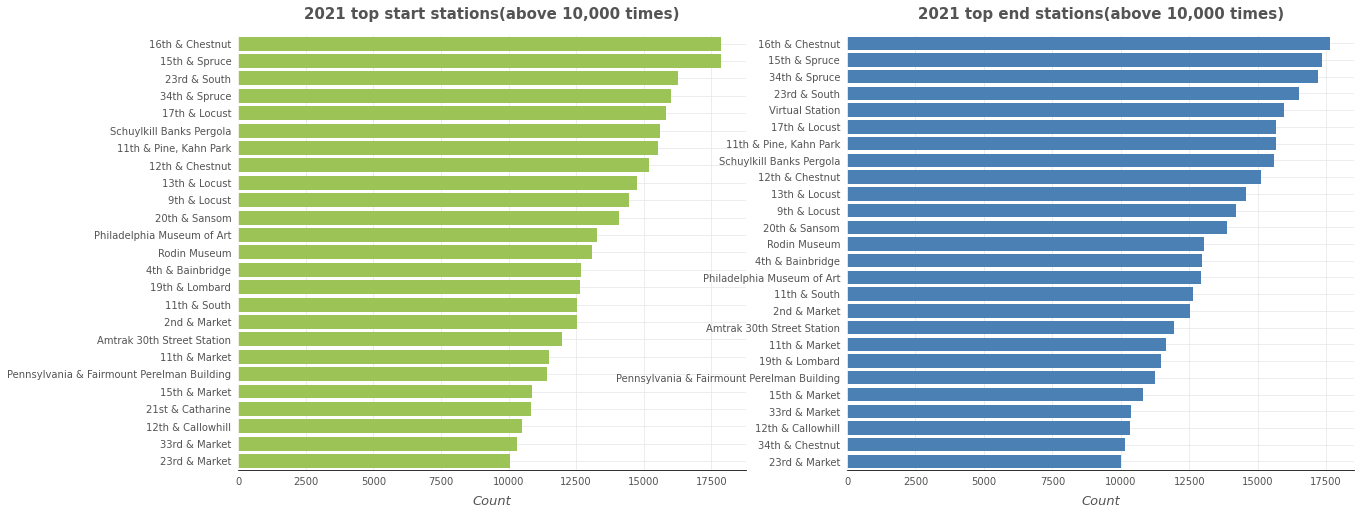

In [ ]:
f, axes = plt.subplots(1,2, figsize=(20, 8))

sns.barplot(x="count", y="Station_Name",color='#A2D543', data=start_station_name[start_station_name['count']>10000],ax = axes[0])
plot_conf(axes[0],xlbl= 'Count', t='2021 top start stations(above 10,000 times)', ticklbl_size=10, lbl_size=13)

sns.barplot(x="count", y="Station_Name",color='#3880C5', data=end_station_name[end_station_name['count']>10000],ax = axes[1])
plot_conf(axes[1],xlbl= 'Count', t='2021 top end stations(above 10,000 times)', ticklbl_size=10, lbl_size=13)

In [ ]:
# Plot net outflow
# Create df of top 30 stations
top30_start = start_station.sort_values(by='count',ascending=False).head(30).reset_index()
top30_end = end_station.sort_values(by='count',ascending=False).head(30).reset_index()
top_both = top30_start.merge(top30_end,left_on='start_station',right_on='end_station', how='outer')

top_both['outflow']=top_both['count_x']-top_both['count_y']
top_both.sort_values(by='outflow',ascending=False)

top_start_flow = start_station.reset_index()
top_end_flow = end_station.reset_index()
top_both_flow = top_start_flow.merge(top_end_flow,left_on='start_station',right_on='end_station', how='outer')
top_both_flow['outflow']=top_both_flow['count_x']-top_both_flow['count_y']
top_both_flow_sorted = top_both_flow.sort_values(by='outflow',ascending=False).reset_index().iloc[0:-2,:]

([], <a list of 0 Text major ticklabel objects>)

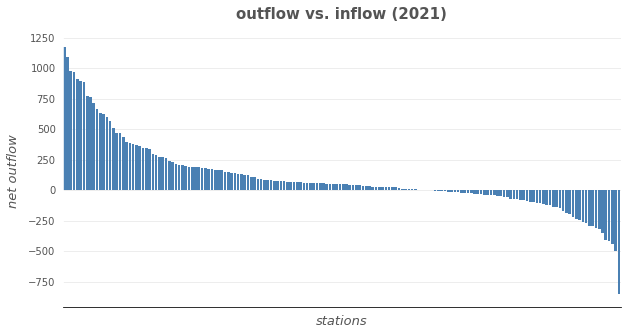

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.barplot(x="start_station", y="outflow",color='#3880C5', data=top_both_flow_sorted)
plot_conf(ax,xlbl= 'stations',ylbl='net outflow', t='outflow vs. inflow (2021)', ticklbl_size=10, lbl_size=13)
plt.xticks([])

#plt.savefig('net_outflow.jpg')

**Insight:** We also map out the most frequent routes, routes that have more than 20 same trips in 2021, with top inflow and outflow stations represented by blue and green points respectively. The darker the colors they are, the high the net inflow or outflow stations are. Find out more about our storymap in [ArcGIS Storymap](https://storymaps.arcgis.com/stories/5738aa98018947ad801945f131254957)!

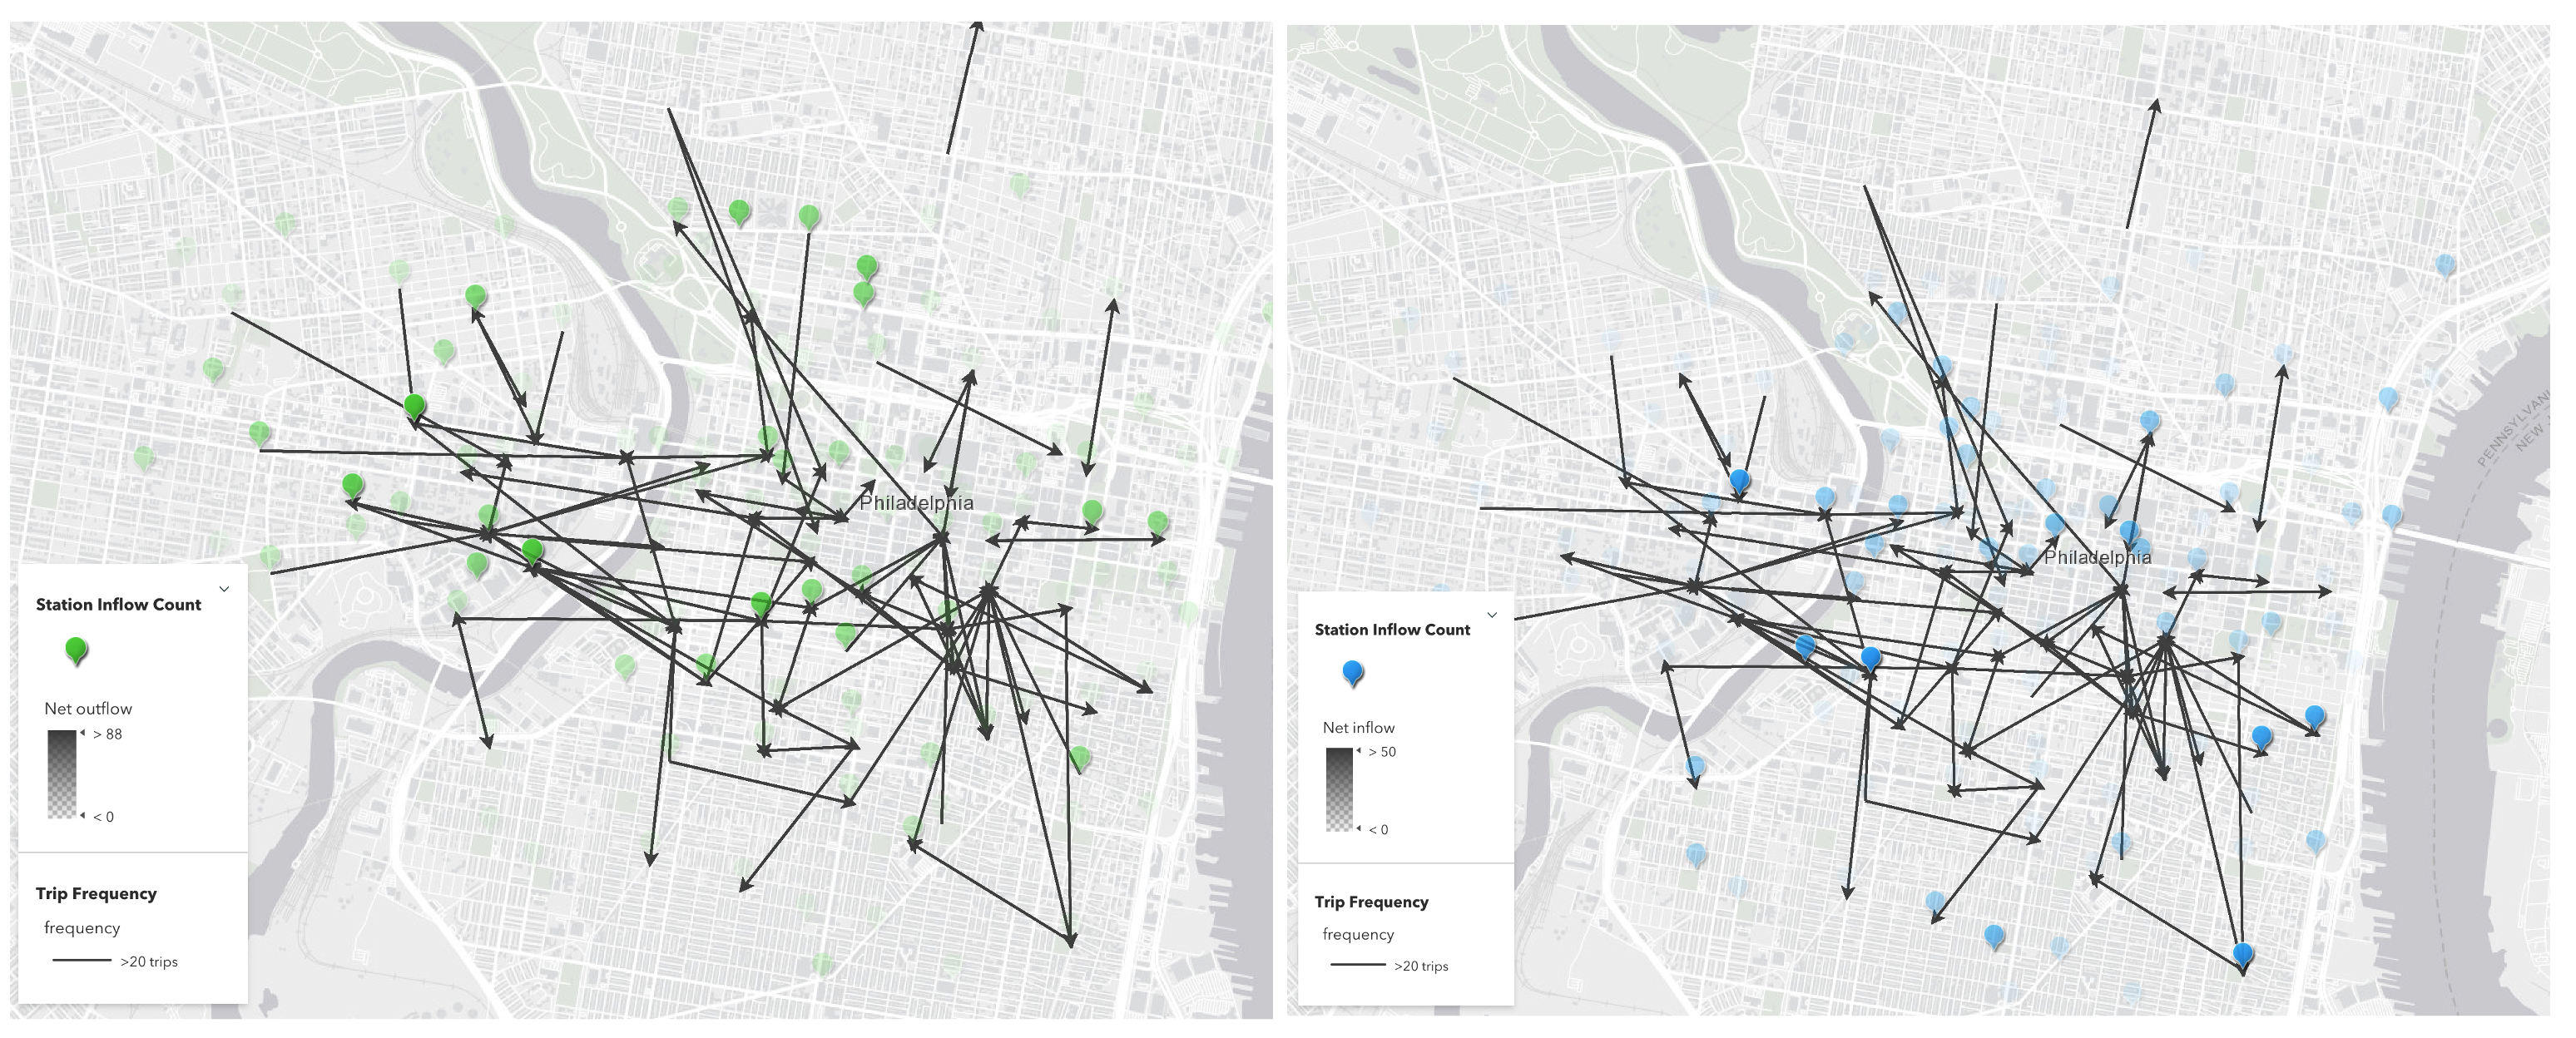

## Time Series Data EDA


---

For this part, we have some basic plots for time series data, checking if there is a specific pattern exist, which will be helpful in the modeling part.

Reference: https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 


### Test trend and stationarity


---

**Motivation:** It is important to have our time series staionary to apply ARIMA model for forecasting. So, at the beginning, we can have a quick look at the stationariy with simple line plot.

**Insight:** It seems that our time series is relative stationary, which is good for modeling, and we don't need to difference it again. But still, we will use ADF test to ensure the stationarity before we build our models.

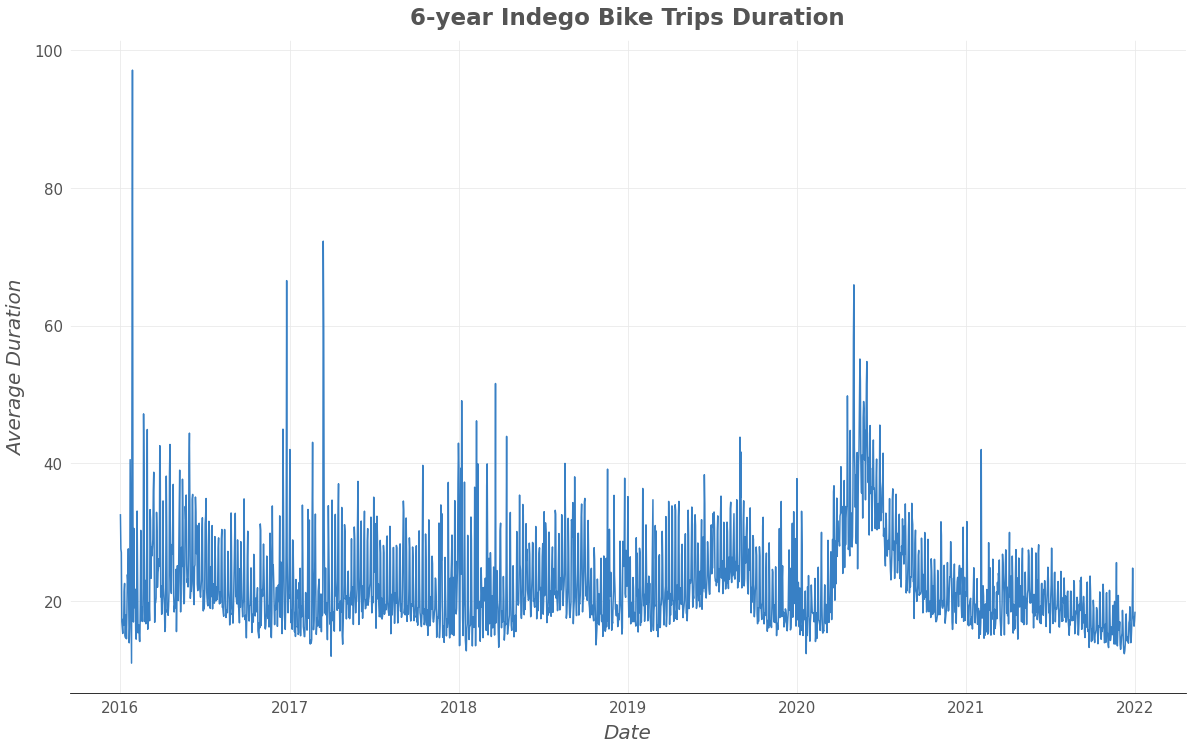

In [ ]:
# Plot time series
plt.figure(figsize=(20,12))

ax = sns.lineplot(x=ddf_6yr.index,y='duration',data=ddf_6yr,color='C2')

plot_conf(ax, xlbl='Date', ylbl='Average Duration', t='6-year Indego Bike Trips Duration', ticklbl_size=15, lbl_size=20,tsize = 23)
#plt.savefig('time_series.jpg')

### Test seasonality
---

**Motivation:** Seasonality is another important feature of time series data. It has a big influence on ways to predict.

**Method:**We will check whether this series data has seasonality by testing autocorrelation.

**Insight:** According to the plot, autocorrelation dropped from nearly 0.6 to almost 0, and has a repetitive pattern, which means the data has seasonality.

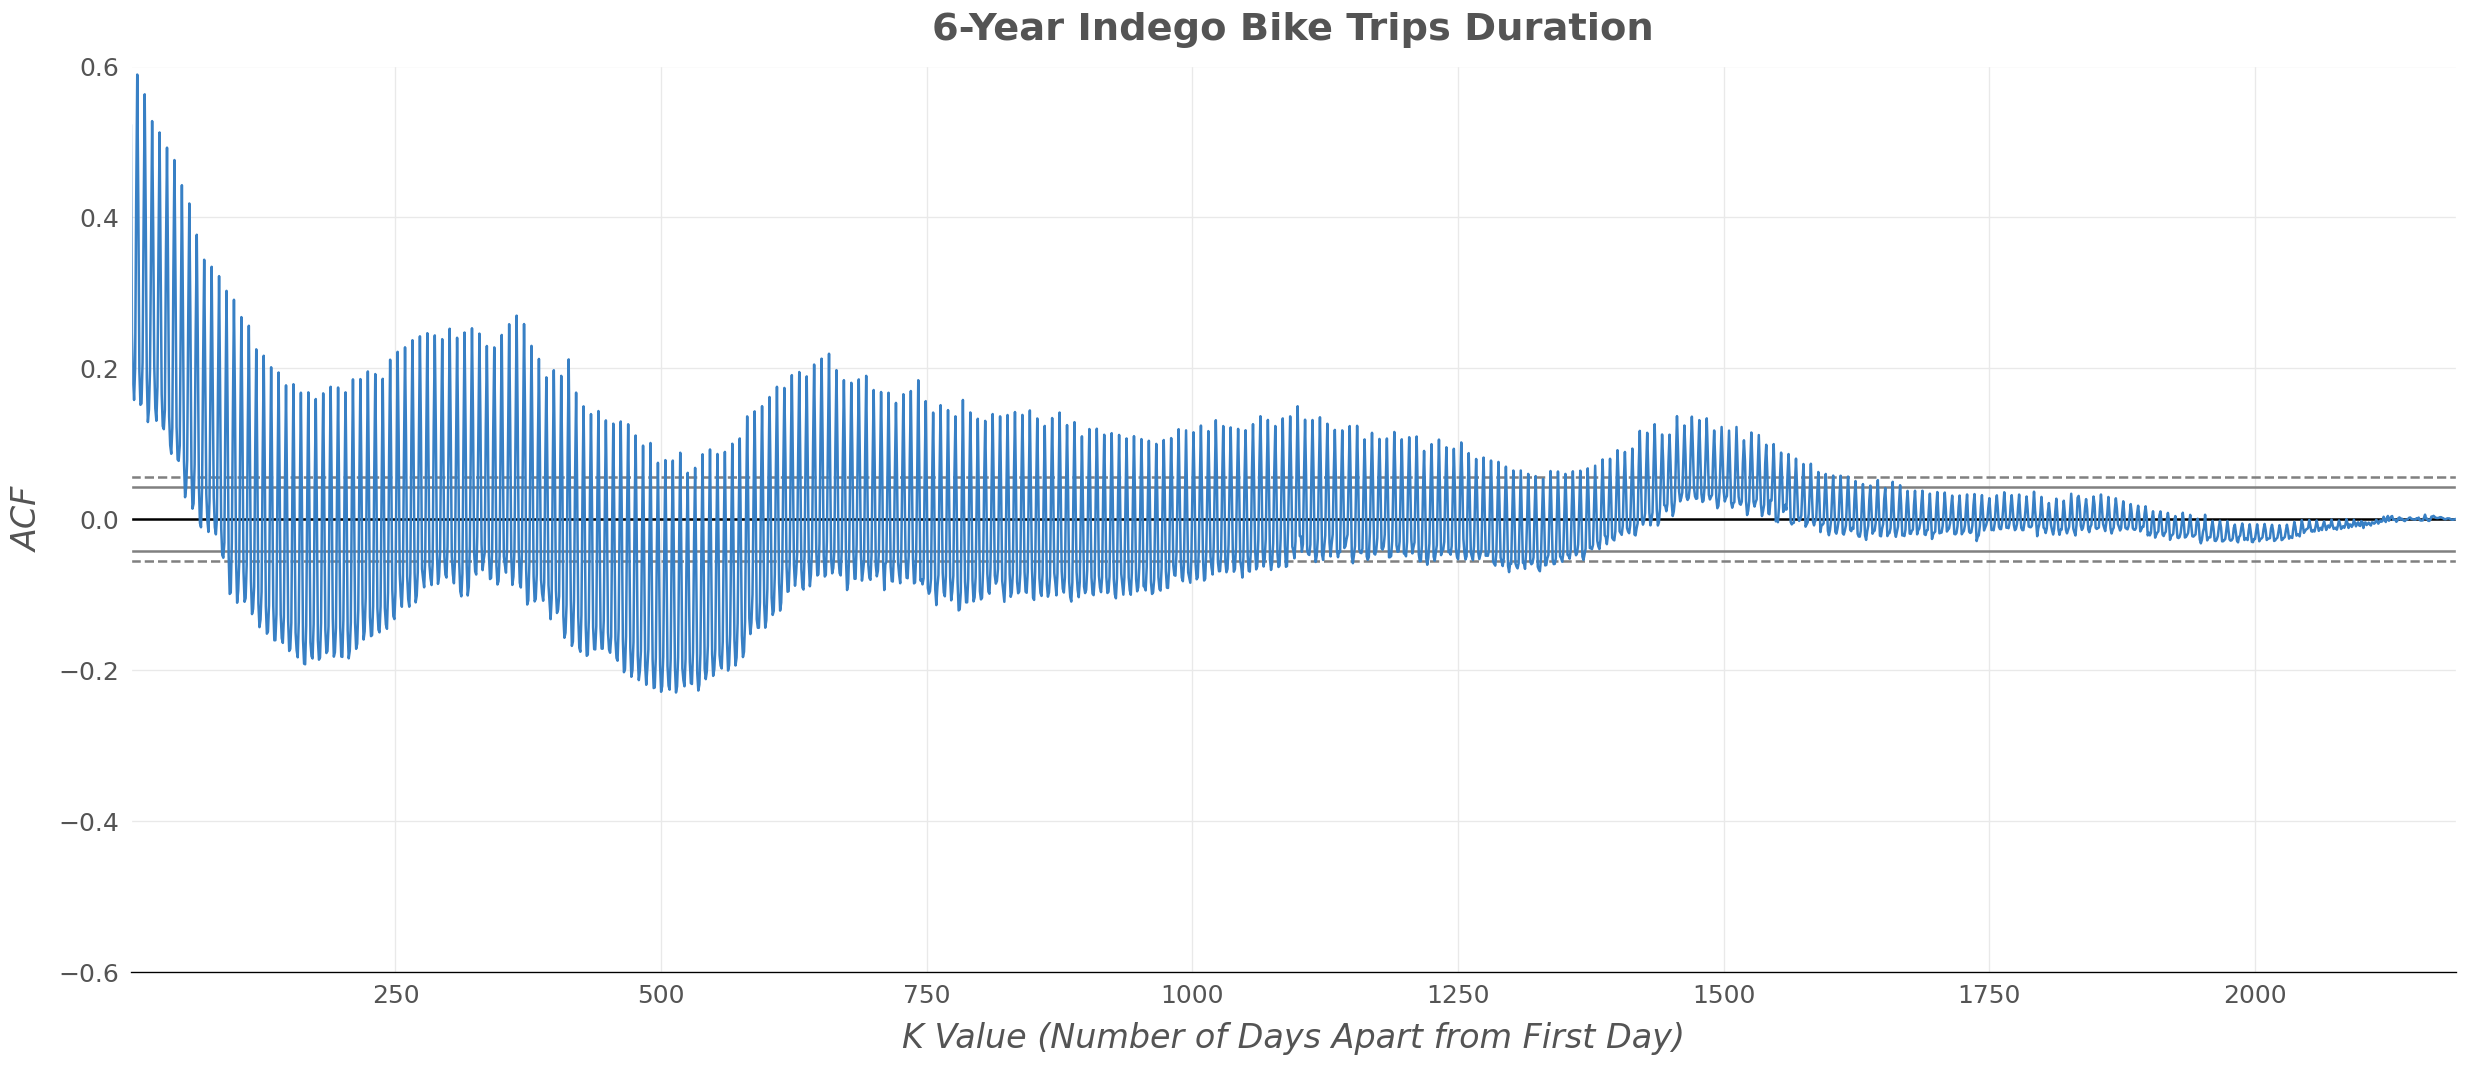

In [ ]:
# Test seasonality with Autocorrelation Function (ACF) 
plt.rcParams.update({'figure.figsize':(25,10), 'figure.dpi':120})
ax = autocorrelation_plot(ddf_6yr.duration.tolist(),color='C2')
plt.ylim(-0.6,0.6)
plot_conf(ax, xlbl='K Value (Number of Days Apart from First Day)', ylbl='ACF', t='6-Year Indego Bike Trips Duration', ticklbl_size=15, lbl_size=20,tsize=23)
#plt.savefig('ACF.jpg')


### Monthly lineplot
---

**Motivation:** We already know about the seasonality, but what it exactly looks like? We want to show it by plotting the repetitive pattern across different years.

**Insight:** Although it is not that obvious, we can see that each year, there is more use of the Indego bike in the spring and summer, and less use in the winter, which supports our hypothesis that people are more likely to ride in warm weather. However, the month of May 2020 stands out in this graph, with an extraordinarily high total duration value. We looked for some information and suspect that the incident is tied to an activity that Indego was doing at the time. Indego announced a monthly pass discount with the price $5 on April 23, 2020, to assist individuals going out during the pandemic.

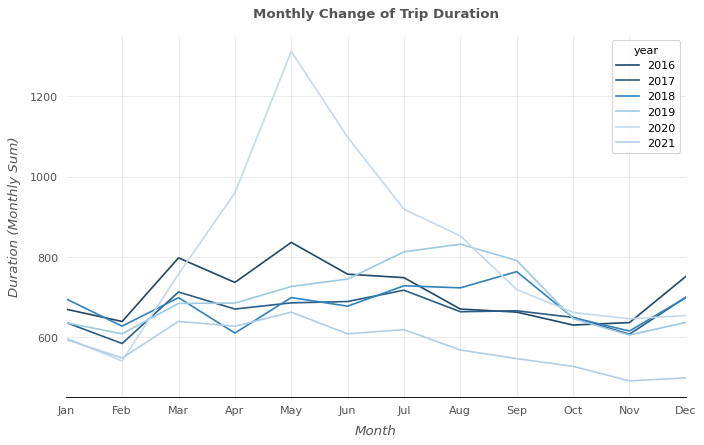

In [ ]:
# Plot what is the seasonality precisely like

# extract year & month from dataframe
ddf_6yr['year'] = [d.year for d in ddf_6yr.index]
ddf_6yr['month'] = [d.month for d in ddf_6yr.index]
years = ddf_6yr['year'].unique()
ddf_6yr_month = ddf_6yr.reset_index().groupby(['year','month']).sum().reset_index()


# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)

ax = sns.lineplot(data=ddf_6yr_month,x='month',y='duration',hue='year',palette=['#214868','#2b5d87','#3182bd','#9ecae1','#c4d9ec','#b1cee6'])
plot_conf(ax, xlbl='Month', ylbl='Duration (Monthly Sum)', t='Monthly Change of Trip Duration', ticklbl_size=10, lbl_size=12, tsize=12)
plt.xticks(range(13),['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.margins(x=0)
#plt.savefig('Lineplot_6yr_month_change.jpg')


### Boxplots for trend and seasonality
---

**Motivation:** We have the plot for trend within each year, but what about the average trend and seasonality during the past 6 years?

**Insight:** These boxplots confirmed our conclusion, which is that trip duration has not changed based on a trend in recent years, and people bike longer in warm days.

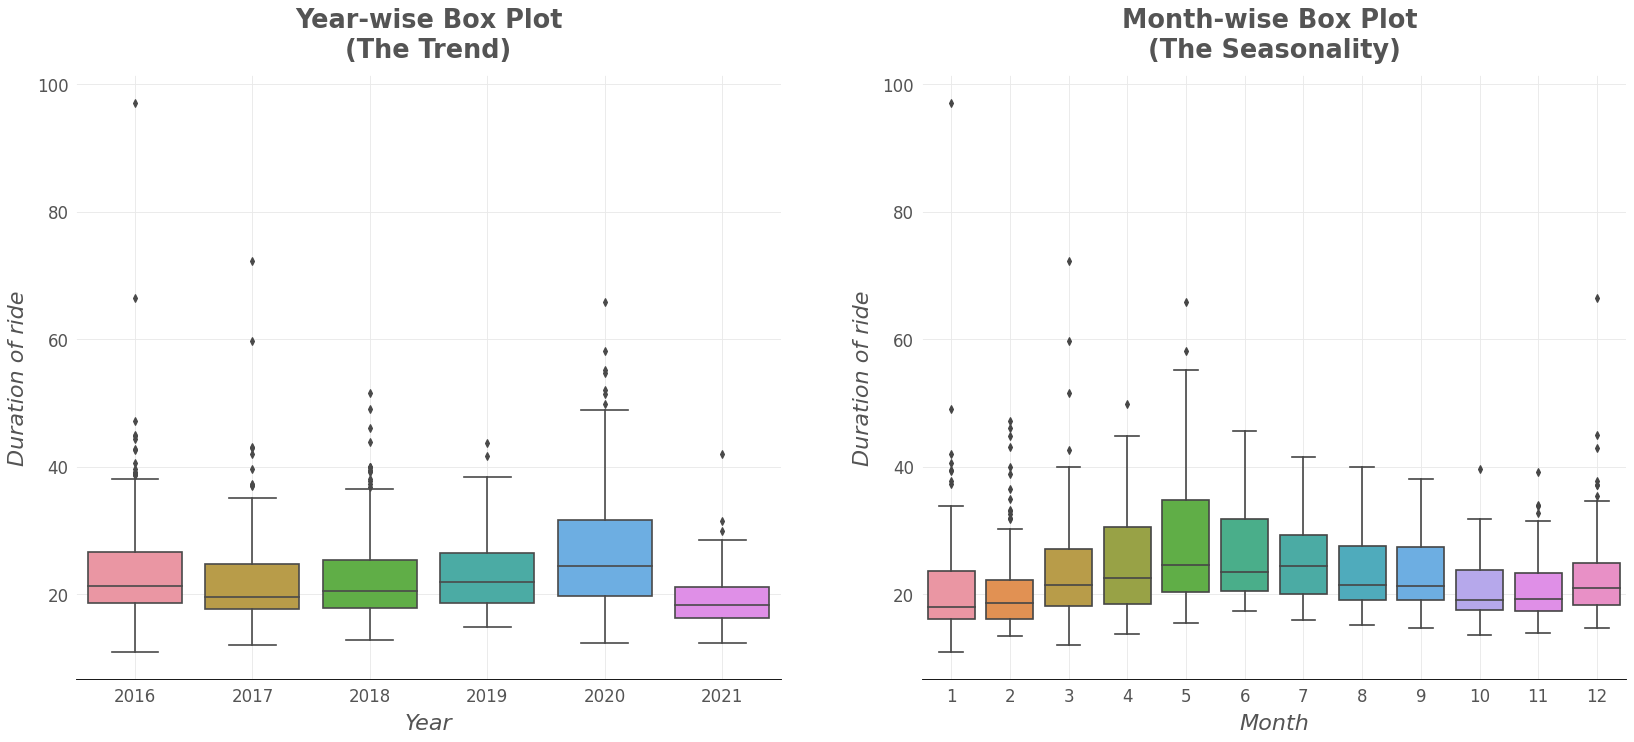

In [ ]:
# Boxplot of Month-wise (Seasonal)

fig, axes = plt.subplots(1, 2, figsize=(25,10), dpi= 80)
sns.boxplot(x='year', y='duration', data=ddf_6yr, ax=axes[0])
sns.boxplot(x='month', y='duration', data=ddf_6yr.loc[~ddf_6yr.year.isin([2019,2021]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
#plt.show()

plot_conf(axes[0],xlbl= 'Year',ylbl='Duration of ride', t='Year-wise Box Plot\n(The Trend)', ticklbl_size=15, lbl_size=20,tsize=23)
plot_conf(axes[1],xlbl= 'Month',ylbl='Duration of ride', t='Month-wise Box Plot \n(The Seasonality)', ticklbl_size=15, lbl_size=20,tsize=23)
#plt.savefig('Boxplot.jpg')


# Feature Engineering

## Feature Selection


---

Based on our analysis, we will choose the statistical variables that might correlate with duration. We will exclude indexing or other variables such as lat and lon that have little relation with our predicted variable.

In [ ]:
ddf_2021.head(1)

trip_id  duration          start_time            end_time  start_station  \
0  365184634        15 2021-01-01 00:05:00 2021-01-01 00:20:00           3125   

   start_lat  start_lon  end_station    end_lat    end_lon bike_id  \
0  39.943909 -75.167351         3157  39.925449 -75.159538   14542   

   plan_duration trip_route_category passholder_type bike_type  \
0             30             One Way        Indego30  standard   

  start_time_date start_time_year start_time_month start_time_hour  \
0      01-01-2021            2021               01              00   

  start_time_day start_dayOfWeek start_dayOfWeek.name  start_dayOfYear  \
0             01               5               Friday                1   

  start_weekOfYear.name          dt                         dt_iso  timezone  \
0                    00  1609477200  2021-01-01 05:00:00 +0000 UTC    -18000   

      city_name        lat        lon       temp  visibility   dew_point  \
0  Philadelphia  39.952583 -75.165222  275.01001     10000.0  269.959991   

   feels_like    temp_min  temp_max  pressure  sea_level  grnd_level  \
0   275.01001  273.130005     276.0      1030        NaN         NaN   

   humidity  wind_speed  wind_deg  wind_gust  rain_1h  rain_3h  snow_1h  \
0        67        0.89       306       3.13      NaN      NaN      NaN   

   snow_3h  clouds_all  weather_id weather_main weather_description  \
0      NaN          20         801       Clouds          few clouds   

  weather_icon                   UTCtime    ESTtime ESTtime_date ESTtime_hour  \
0          02n 2021-01-01 05:00:00+00:00 2021-01-01   01-01-2021           00   

  _merge DurationRange  
0   both   0 to 15 min

Add the predicted variable 'above_average', which transforms the continuous values into two categories, 0 denotes a ride is under average and 1 denotes larger or equals to average duration

In [ ]:
meandur = ddf_2021['duration'].mean()
ddf_2021['above_average'] = ddf_2021['duration'].apply(lambda row : 0 if row < meandur else 1)

In [ ]:
# columns/features selected for use in modelling
col_use = ['duration','plan_duration','trip_route_category','passholder_type','bike_type',\
           'start_time_month','start_time_hour','start_time_day','start_dayOfWeek','start_dayOfYear',\
           'temp','visibility','dew_point','feels_like','temp_min','temp_max','pressure','humidity','wind_speed','wind_deg','wind_gust',\
           'rain_1h','snow_1h','weather_description','above_average']

## Impute Missing Values

Since rain and snow are not everyday weather, Nans in rain and snow data can be recognized as no rain or snow on that day, so we fill the na with 0

In [ ]:
mddf_2021= ddf_2021[col_use]
mddf_2021['rain_1h'].fillna(0, inplace=True)
mddf_2021['snow_1h'].fillna(0, inplace=True)
mddf_2021 = mddf_2021.dropna()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
ddf_2021[col_use].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976350 entries, 0 to 976349
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   duration             976350 non-null  int64   
 1   plan_duration        976350 non-null  int64   
 2   trip_route_category  976350 non-null  category
 3   passholder_type      976349 non-null  category
 4   bike_type            976350 non-null  category
 5   start_time_month     976350 non-null  category
 6   start_time_hour      976350 non-null  category
 7   start_time_day       976350 non-null  category
 8   start_dayOfWeek      976350 non-null  category
 9   start_dayOfYear      976350 non-null  int64   
 10  temp                 976350 non-null  float32 
 11  visibility           969349 non-null  float32 
 12  dew_point            976350 non-null  float32 
 13  feels_like           976350 non-null  float32 
 14  temp_min             976350 non-null  float32 
 15  

In [ ]:
mddf_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928081 entries, 0 to 976349
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   duration             928081 non-null  int64   
 1   plan_duration        928081 non-null  int64   
 2   trip_route_category  928081 non-null  category
 3   passholder_type      928081 non-null  category
 4   bike_type            928081 non-null  category
 5   start_time_month     928081 non-null  category
 6   start_time_hour      928081 non-null  category
 7   start_time_day       928081 non-null  category
 8   start_dayOfWeek      928081 non-null  category
 9   start_dayOfYear      928081 non-null  int64   
 10  temp                 928081 non-null  float32 
 11  visibility           928081 non-null  float32 
 12  dew_point            928081 non-null  float32 
 13  feels_like           928081 non-null  float32 
 14  temp_min             928081 non-null  float32 
 15  

In [ ]:
mddf_2021.head(1)

duration  plan_duration trip_route_category passholder_type bike_type  \
0        15             30             One Way        Indego30  standard   

  start_time_month start_time_hour start_time_day start_dayOfWeek  \
0               01              00             01               5   

   start_dayOfYear       temp  visibility   dew_point  feels_like    temp_min  \
0                1  275.01001     10000.0  269.959991   275.01001  273.130005   

   temp_max  pressure  humidity  wind_speed  wind_deg  wind_gust  rain_1h  \
0     276.0      1030        67        0.89       306       3.13      0.0   

   snow_1h weather_description  above_average  
0      0.0          few clouds              0

## Label-Encode Cateogorical Variables

In [ ]:
# map weather based on intensity
weather_mapping = { 'sky is clear': 0,
                    'few clouds': 1,
                    'scattered clouds': 2,
                    'broken clouds': 3,
                    'overcast clouds': 4,
                    'mist': 5,                  
                    'smoke': 6,
                    'haze': 7,                  
                    'fog': 8,
                    'squalls': 9,
                    'light intensity drizzle': 10,
                    'drizzle': 11,
                    'light rain': 12,
                    'light snow': 13,
                    'thunderstorm with light rain': 14,
                    'moderate rain': 15,                         
                    'thunderstorm with rain': 16, 
                    'snow': 17,                   
                    'heavy intensity rain': 18,
                    'thunderstorm with heavy rain': 19,
                    'thunderstorm': 20,
                    'very heavy rain': 21,
                    'heavy snow': 22}
mddf_2021['weather_description'] = mddf_2021['weather_description'].map(weather_mapping)

In [ ]:
np.sort(mddf_2021['weather_description'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
mddf_2021['trip_route_category'] = le.fit_transform(mddf_2021['trip_route_category']) # encode trip_route_category
trip_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

mddf_2021['passholder_type'] = le.fit_transform(mddf_2021['passholder_type'])  # encode passholder_type
passholder_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

mddf_2021['bike_type'] = le.fit_transform(mddf_2021['bike_type'])    # encode bike_type
biketype_mapping = dict(zip(le.classes_, le.transform(le.classes_)))


In [ ]:
passholder_mapping

{'Day Pass': 0, 'Indego30': 1, 'Indego365': 2, 'Walk-up': 3}

In [ ]:
mddf_2021.head(1)

duration  plan_duration  trip_route_category  passholder_type  bike_type  \
0        15             30                    0                1          1   

  start_time_month start_time_hour start_time_day start_dayOfWeek  \
0               01              00             01               5   

   start_dayOfYear       temp  visibility   dew_point  feels_like    temp_min  \
0                1  275.01001     10000.0  269.959991   275.01001  273.130005   

   temp_max  pressure  humidity  wind_speed  wind_deg  wind_gust  rain_1h  \
0     276.0      1030        67        0.89       306       3.13      0.0   

   snow_1h weather_description  above_average  
0      0.0                   1              0

## Correlation Inspection

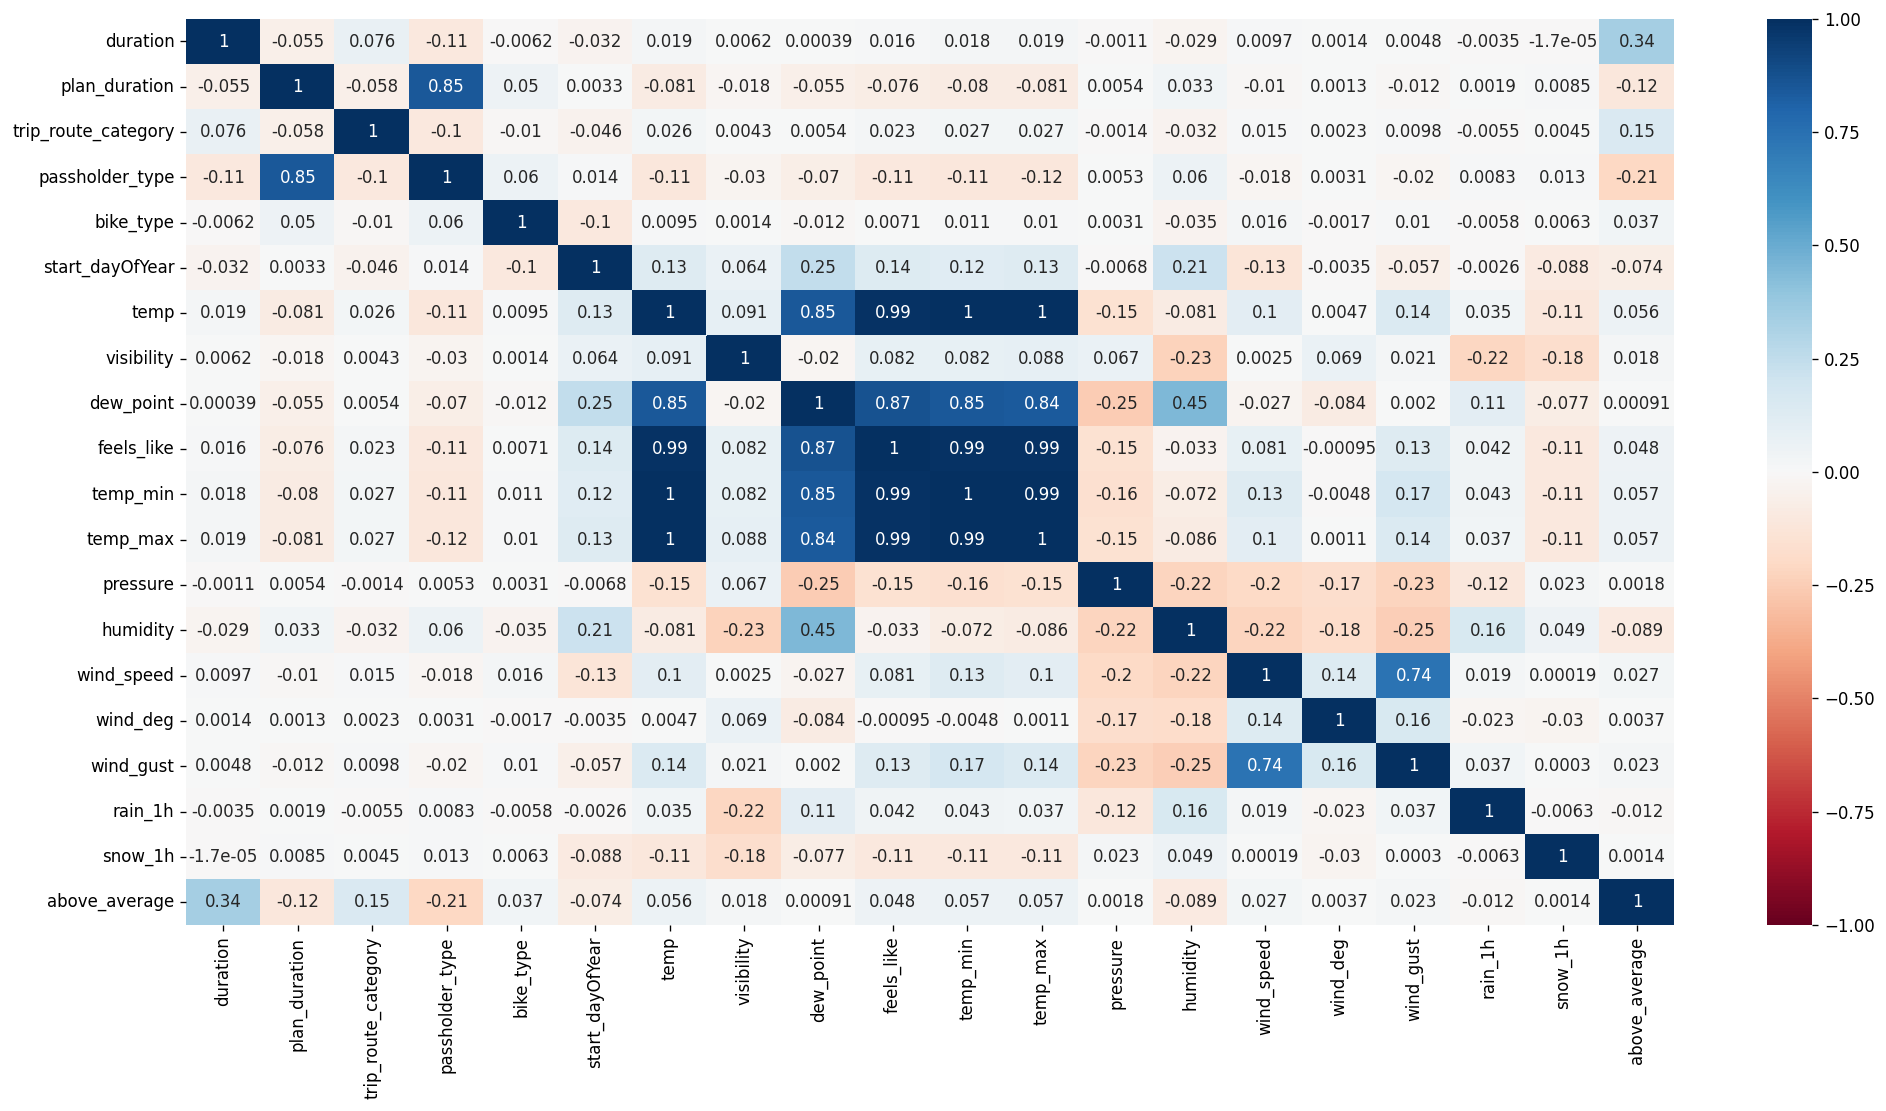

In [ ]:
df_cor = mddf_2021.corr()
plt.figure(figsize=(20,10))
sns.heatmap(df_cor,annot=True,cmap="RdBu",vmin=1, vmax=-1)

# Classification Modeling


---
In this session, we will predict whether a trip will be above average duration or not using classification models. Models will be trained using Apache Spark ML, a powerful distributed machine learning library. The reasons why we chose Spark ML are:


*   We are analyzing "big" data that requires heavy iterative computations on large dataset with around 92,0000 entries of data
*   Standard ML library such as Sklearn are slow in running, especially when running tree models
*   Distribute the computation into multiple machines instead of using one single high-end machine, which is extremely friendly to notebook running in a laptop with less computation capacity 



So let's get started building some ML models with Spark ML!





## Initialize Spark ML

In [ ]:
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
0 upgraded, 7 newly installed, 0 to remove and 42 not upgraded.
Need to get 349 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.2 [54.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.2 [37.3 kB]
Get:3 http://archive.ubu

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-hw4').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
# Graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

Initializing Spark Data

In [ ]:
mddf_2021.to_csv('mddf_2021.csv')

In [ ]:
smddf_2021=spark.read.csv('mddf_2021.csv',header = True, inferSchema = True) 
smddf_2021.show()

+---+--------+-------------+-------------------+---------------+---------+----------------+---------------+--------------+---------------+---------------+------+----------+---------+----------+--------+--------+--------+--------+----------+--------+---------+-------+-------+-------------------+-------------+
|_c0|duration|plan_duration|trip_route_category|passholder_type|bike_type|start_time_month|start_time_hour|start_time_day|start_dayOfWeek|start_dayOfYear|  temp|visibility|dew_point|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|wind_deg|wind_gust|rain_1h|snow_1h|weather_description|above_average|
+---+--------+-------------+-------------------+---------------+---------+----------------+---------------+--------------+---------------+---------------+------+----------+---------+----------+--------+--------+--------+--------+----------+--------+---------+-------+-------+-------------------+-------------+
|  0|      15|           30|                  0|              1|      

In [ ]:
smddf_2021.printSchema() # check schema to ensure the type of columns

root
 |-- _c0: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- plan_duration: integer (nullable = true)
 |-- trip_route_category: integer (nullable = true)
 |-- passholder_type: integer (nullable = true)
 |-- bike_type: integer (nullable = true)
 |-- start_time_month: integer (nullable = true)
 |-- start_time_hour: integer (nullable = true)
 |-- start_time_day: integer (nullable = true)
 |-- start_dayOfWeek: integer (nullable = true)
 |-- start_dayOfYear: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- dew_point: double (nullable = true)
 |-- feels_like: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- pressure: integer (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- wind_deg: integer (nullable = true)
 |-- wind_gust: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |--

## Model Preparation

---
We will follow the steps below to prepare for model training and testing:

*   Create pipeline to assemble featres columns into one output columns in 
spark dataframe
*   Split train and test datasets
*   Standardize/scale the features for scale-sensitive models such as logistic models with regularizations and PCA






In [ ]:
col_feature = ['plan_duration','trip_route_category','passholder_type','bike_type',\
             'start_time_month','start_time_hour','start_time_day','start_dayOfWeek','start_dayOfYear',\
             'temp','visibility','dew_point','feels_like','temp_min','temp_max','pressure','humidity','wind_speed','wind_deg','wind_gust',\
             'rain_1h','snow_1h','weather_description']

In [ ]:
len(col_feature)

23

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

assembler = VectorAssembler(inputCols = col_feature, outputCol = "features")

from pyspark.ml import Pipeline
pipe  = Pipeline(stages = [assembler])
modified_smddf_2021 = pipe.fit(smddf_2021).transform(smddf_2021)

In [ ]:
modified_smddf_2021.show()

+---+--------+-------------+-------------------+---------------+---------+----------------+---------------+--------------+---------------+---------------+------+----------+---------+----------+--------+--------+--------+--------+----------+--------+---------+-------+-------+-------------------+-------------+--------------------+
|_c0|duration|plan_duration|trip_route_category|passholder_type|bike_type|start_time_month|start_time_hour|start_time_day|start_dayOfWeek|start_dayOfYear|  temp|visibility|dew_point|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|wind_deg|wind_gust|rain_1h|snow_1h|weather_description|above_average|            features|
+---+--------+-------------+-------------------+---------------+---------+----------------+---------------+--------------+---------------+---------------+------+----------+---------+----------+--------+--------+--------+--------+----------+--------+---------+-------+-------+-------------------+-------------+--------------------+
|  0|  

In [ ]:
# split the data into train(80%) and test(20%) datasets 
train_sdf, test_sdf = modified_smddf_2021.randomSplit([0.8, 0.2], seed = 21)

In [ ]:
from pyspark.ml.feature import StandardScaler

# StandardScaler training data
scaler = StandardScaler(inputCol="features", outputCol="variable", withStd=True, withMean=True)
scalerModel = scaler.fit(train_sdf)
train_sdf = scalerModel.transform(train_sdf)
#scaler_train_sdf.show()

# StandardScaler testing data
test_sdf = scalerModel.transform(test_sdf) # only transform not fit

In [ ]:
#mddf_2021.isna().sum()

## Logistic Regression

First and foremost, we will use regular Logistic regression models to train our data. We will firstly train a Logistic regression model without any regularization.

As we know, L1/Lasso regularization can perform feature selection by shrinking the unimportant features to zero while L2/Ridge helps prevent overfitting by forcing weights to be small, but not making them exactly 0. The Elastic Net is a combination of L1/L2 regularization that seeks to balance two penalties by giving each a weight.

So training a logistic regression without regularizations would not be perfect. We will then add penalty to avoid overfitting with additional 3 models with regularization of L1/Lasso, L2/Ridge, and Elastic Net to see how they might make any improvements.



**Model 1: Train a Logistic Regression Model without any Regularization**

In [ ]:
from pyspark.ml.classification import LogisticRegression
logit = LogisticRegression(featuresCol = "variable", labelCol = "above_average", maxIter = 10)
logit = logit.fit(train_sdf)
predictions_train = logit.transform(train_sdf)
predictions_test = logit.transform(test_sdf)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='above_average')

# TO-DO: Get training accuracy and save to variable called "training_accuracy"
training_accuracy = evaluator.evaluate(predictions_train)   

# TO-DO: Get AUC ROC score and save to variable called "test_predictions_log"
test_predictions_log = evaluator.evaluate(predictions_test,                      
                                         {evaluator.metricName: "areaUnderROC"})

#print(training_accuracy, test_predictions_log)
print("AUC for train set :{}".format(training_accuracy))
print("AUC for test set : {}".format(test_predictions_log))

AUC for train set :0.5601296250674194
AUC for test set : 0.5611530471623631


**Model 2: Train a Logistic Regression Model with L1 Lasso Regularization**

In [ ]:
# LASSO/L1 regularized model's AUC ROC score 
logit_l1 = LogisticRegression(featuresCol = "variable", labelCol = "above_average", maxIter = 10, elasticNetParam=1,regParam=0.3)
logit_l1 = logit_l1.fit(train_sdf)
predictions_train = logit_l1.transform(train_sdf)

# transform test data
predictions_test = logit_l1.transform(test_sdf) 

# evaluate AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='above_average')
training_accuracy  = evaluator.evaluate(predictions_train,
                                        {evaluator.metricName: "areaUnderROC"})
test_area_l1 = evaluator.evaluate(predictions_test,                      
                                         {evaluator.metricName: "areaUnderROC"})
#print(training_accuracy, test_area_l1) 
print("AUC for train set :{}".format(training_accuracy))
print("AUC for test set : {}".format(test_area_l1))

AUC for train set :0.5
AUC for test set : 0.5


**Model 3: Train a Logistic Regression Model with L2 Ridge Regularization**

In [ ]:
# Ridge/L2 regularized model's AUC ROC score
logit_l2 = LogisticRegression(featuresCol = "variable", labelCol = "above_average", maxIter = 10, elasticNetParam=0,regParam=0.3)
logit_l2 = logit_l2.fit(train_sdf)
predictions_train = logit_l2.transform(train_sdf)

# transform test data
predictions_test = logit_l2.transform(test_sdf) 

# evaluate AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='above_average')
training_accuracy  = evaluator.evaluate(predictions_train,
                                        {evaluator.metricName: "areaUnderROC"})
test_area_l2 = evaluator.evaluate(predictions_test,                      
                                         {evaluator.metricName: "areaUnderROC"})

#print(training_accuracy, test_area_l2) 
print("AUC for train set :{}".format(training_accuracy))
print("AUC for test set : {}".format(test_area_l2))

AUC for train set :0.5003898078742478
AUC for test set : 0.5004480793665129


**Model 4: Train a Logistic Regression Model with Elastic Net Regularization**

In [ ]:
# Elastic Net model's AUC ROC score 
logit_elastic = LogisticRegression(featuresCol = "variable", labelCol = "above_average", maxIter = 10, elasticNetParam=0.8,regParam=0.3)
logit_elastic = logit_elastic.fit(train_sdf)
predictions_train = logit_elastic.transform(train_sdf)

# transform test data
predictions_test = logit_elastic.transform(test_sdf)

# evaluate AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='above_average')
training_accuracy  = evaluator.evaluate(predictions_train,
                                        {evaluator.metricName: "areaUnderROC"})
test_area_elastic = evaluator.evaluate(predictions_test,                      
                                         {evaluator.metricName: "areaUnderROC"})
#print(test_area_elastic)
print("AUC for train set :{}".format(training_accuracy))
print("AUC for test set : {}".format(test_area_elastic))

AUC for train set :0.5
AUC for test set : 0.5


The good news is we have a not bad performance using logistic regression. However, adding penalty to the models do not make any difference. We might turn to other models to see how we can improve!

## Random Forest Tree

---

After conducting the logistic regression models, instantly follows a random forest tree, a popular and robust ensemble tree method which work really well with most classification problem.

We will control the number of trees and max depth when training to avoid over time computation.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer

#stringIndexer = StringIndexer(inputCol="features", outputCol="above_average")
rf = RandomForestClassifier(featuresCol = "variable",                           
                            labelCol = "above_average",
                            numTrees=4, maxDepth=2,seed=0)

rf = rf.fit(train_sdf)

train_pred = rf.transform(train_sdf)
test_pred = rf.transform(test_sdf)

In [ ]:
train_area = evaluator.evaluate(train_pred,
                                {evaluator.metricName: "areaUnderROC"})
test_area = evaluator.evaluate(test_pred,
                                {evaluator.metricName: "areaUnderROC"})
#print(train_area, test_area)
print("AUC for train set :{}".format(train_area))
print("AUC for test set : {}".format(test_area))

AUC for train set :0.5
AUC for test set : 0.5


## PCA
---
Since we have 23 columns of features, would the performance improve if we reduce number of dimensions of our features.Next we will use the powerful Principal Component Analysis (PCA) to reduce the dimensions and tranform the data into a lower dimensional scale. Then we will fit a logistic regression with the newly projected PCA features.



In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=len(col_feature),inputCol="variable", outputCol="Main result score")
pcaModel = pca.fit(train_sdf)
result = pcaModel.transform(test_sdf)

print("====Contribution rate====")
print(pcaModel.explainedVariance)

#result_train.show()
cum_evr =  np.cumsum(pcaModel.explainedVariance)
cum_evr


====Contribution rate====
[0.2172226827746674,0.10672871611662663,0.08797872207496026,0.08007383648748492,0.07248845317760037,0.04857173604816525,0.04619621934313123,0.043399681156052444,0.04312148485496416,0.04225780082360064,0.0419530634156597,0.04089992758429768,0.0364508076879264,0.0320345025915542,0.02422530076332926,0.018080423984237072,0.010899828623194737,0.006343418259367616,0.0005400783905030788,0.0003063506111015884,0.00018802661376903185,3.8282921458654114e-05,6.556963476453537e-07]


array([0.21722268, 0.3239514 , 0.41193012, 0.49200396, 0.56449241,
       0.61306415, 0.65926037, 0.70266005, 0.74578153, 0.78803933,
       0.8299924 , 0.87089232, 0.90734313, 0.93937763, 0.96360293,
       0.98168336, 0.99258319, 0.99892661, 0.99946668, 0.99977303,
       0.99996106, 0.99999934, 1.        ])

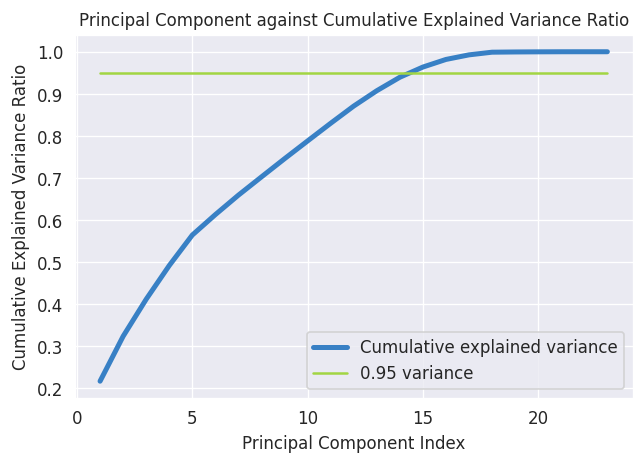

In [ ]:
# find optimal num components to use (n) by plotting explained variance ratio 
plt.figure(figsize=(6,4))
sns.set_style("darkgrid")
plt.plot(range(1,len(cum_evr)+1), cum_evr,label='Cumulative explained variance',linewidth=3)
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.title('Principal Component against Cumulative Explained Variance Ratio',fontsize =10)
plt.plot(range(1,len(cum_evr)+1), [0.95]*len(col_feature),label ='0.95 variance')
plt.legend(loc='best')
plt.show()

When k equals to 14, it reaches 0.95 variance. That means k=4 might be an optimal component to use in reducing dimentions since it has capture almost variance of all the features.

In [ ]:
# find the optimal num components to use (n) 
pca = PCA(k=14,inputCol="variable", outputCol="Main result score")
pcaModel = pca.fit(train_sdf)

# transform the model with PCA features
result_train = pcaModel.transform(train_sdf)
result_test = pcaModel.transform(test_sdf)

In [ ]:
# Train and predict using Logistic Regression model
logit = LogisticRegression(featuresCol = "Main result score", labelCol = "above_average", maxIter = 10)
logit = logit.fit(result_train)

predictions_train = logit.transform(result_train)
predictions_test = logit.transform(result_test)

In [ ]:
# Evaluate predictions on train and test data 
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='above_average')

# Get AUC ROC score for train data
training_ROC_area_pca = evaluator.evaluate(predictions_train,{evaluator.metricName: "areaUnderROC"})

# Get AUC ROC score for test data
test_ROC_area_pca = evaluator.evaluate(predictions_test,{evaluator.metricName: "areaUnderROC"})

#print(training_ROC_area_pca, test_ROC_area_pca)
print("AUC for train set :{}".format(training_ROC_area_pca))
print("AUC for test set : {}".format(test_ROC_area_pca))

AUC for train set :0.531172920150024
AUC for test set : 0.5315580946392146


Compared to random forest tree model, the logistic model using PCA features improved a little bit yet still not as good as the initial logistic models.

## Hyperparameters Tunning


---


Until this point we have train multiple classification models. Among the logistic regression models(with and without regularizations), random forest tree model, PCA model, logistic regression models yield better performance compared to others.

So next we will focus on tuning the hyperparameters of logistic regression models to see whether it can improve the performance

---
Since ElasticNetParam corresponds to $\alpha$ and regParam corresponds to $λ$. The objective of optimization is to minw∈ℝdf(w), where the objective function is of the form $f(w):=λR(w)+1/n ∑_i=1 n L(w;xi,yi)$

The fixed regularization parameter $λ$≥0 (regParam in the code) defines the trade-off between the two goals of minimizing the loss (i.e., training error) and minimizing model complexity (i.e., to avoid overfitting).

While the $\alpha$ defines the weight of L1 and L2 penalty. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. 

---
For the purpose of hyperparameter tuning we will consider using K-fold validation of 5 folds to tune the following parameters:

*   regParam :[0.01, 0.5, 2.0]
*   elasticNetParam: [0, 1]



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
logit = LogisticRegression(featuresCol = "variable", labelCol = "above_average", maxIter = 10)
paramGrid = ParamGridBuilder().addGrid(logit.regParam, [0.01, 0.5, 2.0]).addGrid(logit.elasticNetParam, [0, 1]).build()

crossval = CrossValidator(estimator=logit,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator().setLabelCol('above_average'),
                          numFolds=5,
                          collectSubModels = True)  

cvModel = crossval.fit(train_sdf) # Running cross-validation will return the best model  

In [ ]:
predict_train=cvModel.transform(train_sdf) # Fit with the best model
predict_test=cvModel.transform(test_sdf)
print("AUC for train set after CV :{}".format(evaluator.evaluate(predict_train)))
print("AUC for test set after CV : {}".format(evaluator.evaluate(predict_test)))

AUC for train set after CV :0.5456674475456539
AUC for test set after CV : 0.5459236183911017


Unfortunately we have not seen any significant improvement in the performance metric after tuning the hyperparameters. The initial logistic regression seems to worked just well. 

In [ ]:
#trainingSummary = cvModel.bestModel.summary.accuracy 

# Time Series Model (ARIMA)


---
For this part, we will apply ARIMA model to predict trip duration according to the last 6 years' data.

Reference: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/



## Find the hyperparameter p, d and q


---



*   **p** is for AR term, we will use PACF plot to find it.
*   **d** is the difference we should add to our time series, in order to make our data stationary. 

 As mentioned in the EDA part, we will check the stationarity again with ADF test.
*   **q** is for MA term and ACF plot will help to determine its value.



In [ ]:
# ADF for d
# ADF Guide https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
from statsmodels.tsa.stattools import adfuller
result = adfuller(ddf_6yr.duration, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -3.071960525125587
n_lags: 0.02869903199731096
p-value: 0.02869903199731096
Critial Values:
   1%, -3.433378252128155
Critial Values:
   5%, -2.8628777737918454
Critial Values:
   10%, -2.5674821643200483


**Conclusion:**

 p-value  is smaller than significance level of 0.05 and the ADF statistic is lower than 5% critical value. So, we can reject the null hypothesis, which means our time series is stationary, and we can keep d=0.

<Figure size 960x600 with 0 Axes>

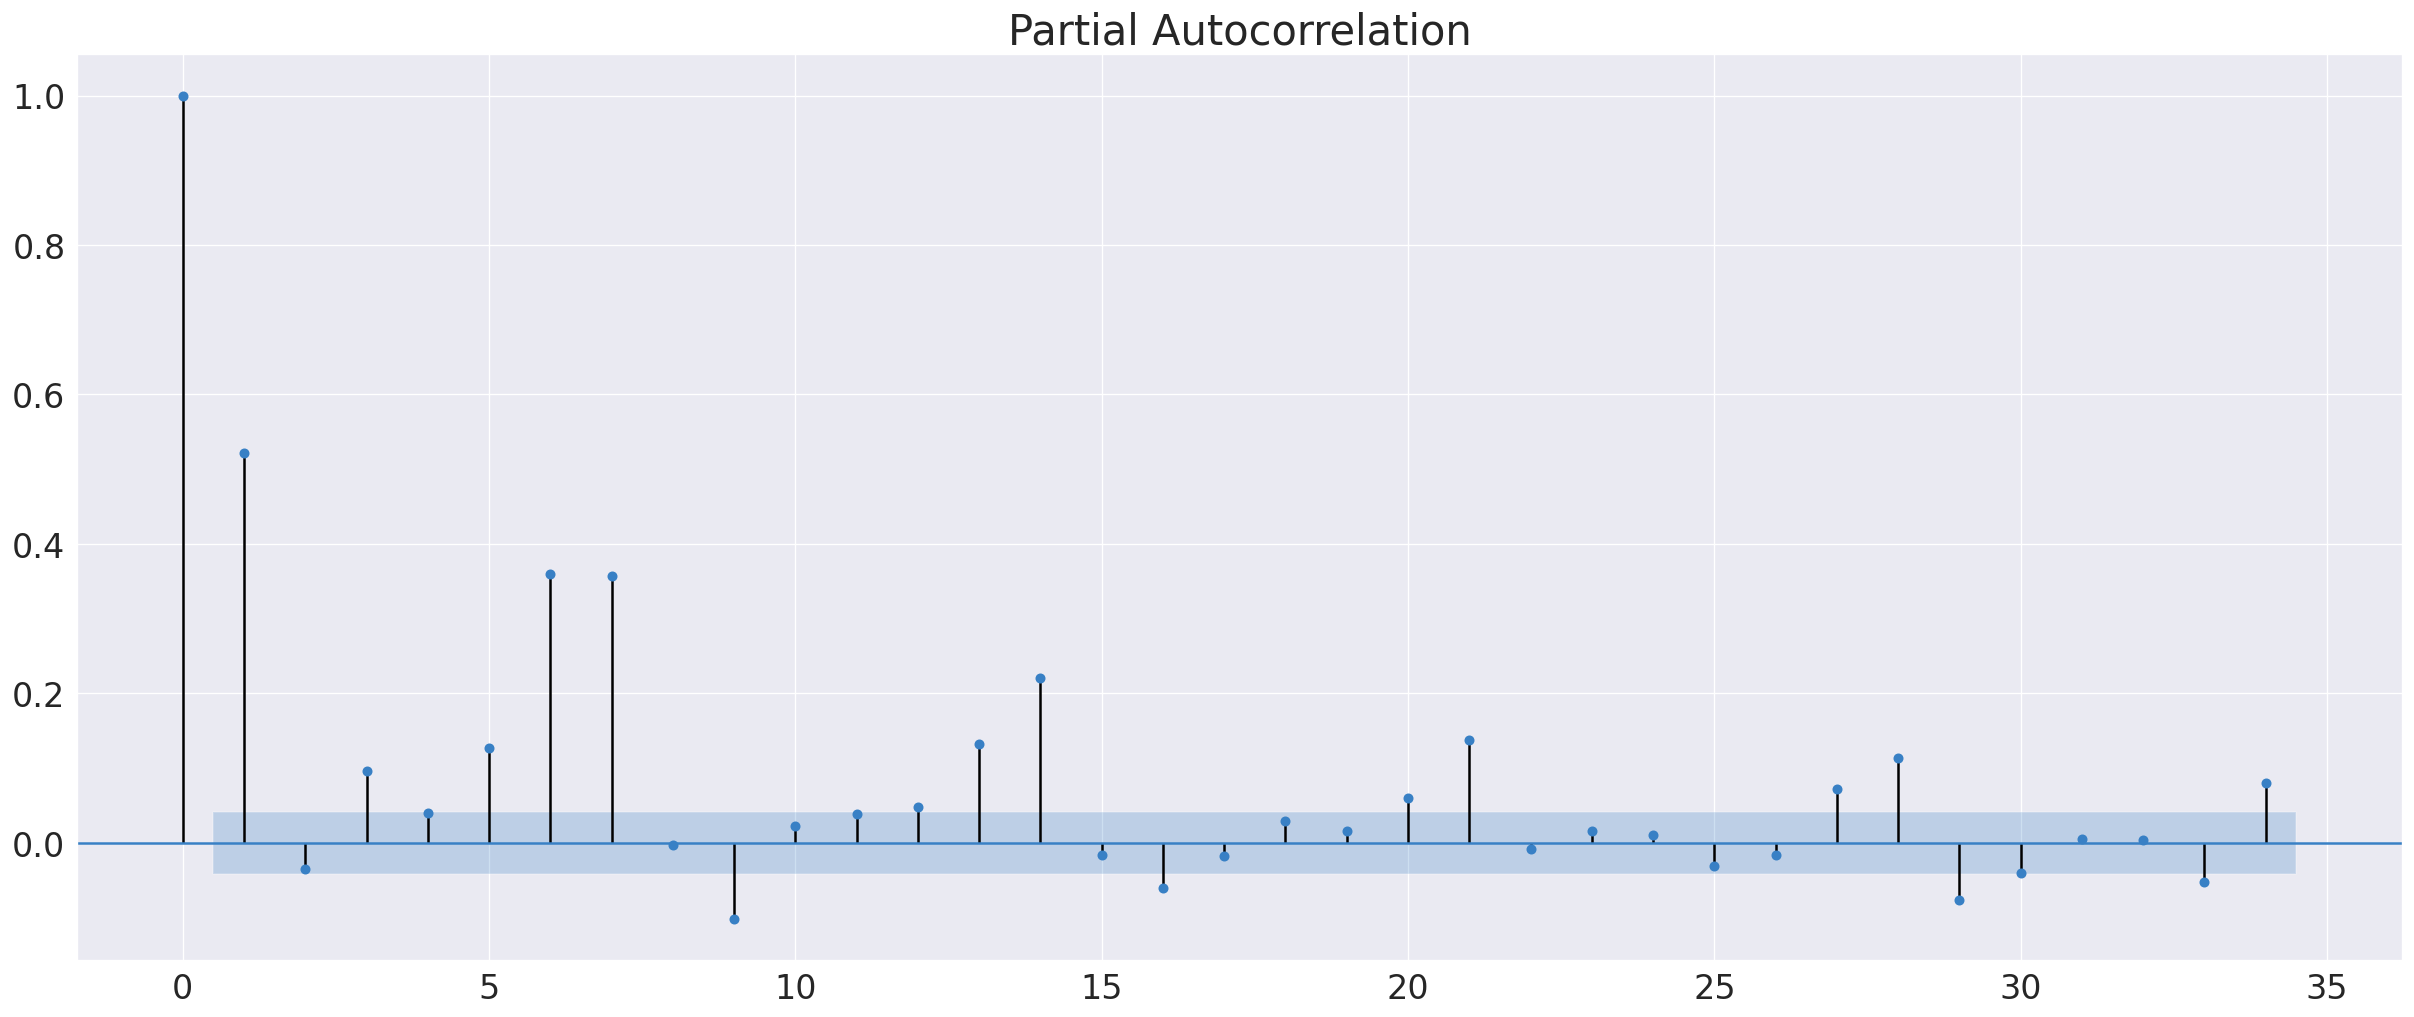

In [ ]:
from numpy.core.fromnumeric import size
# Use PACF plot to find p 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(8,5))
plot_pacf(ddf_6yr.duration)
plt.title('Partial Autocorrelation',fontsize=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('PACF_p.jpg')

<Figure size 960x600 with 0 Axes>

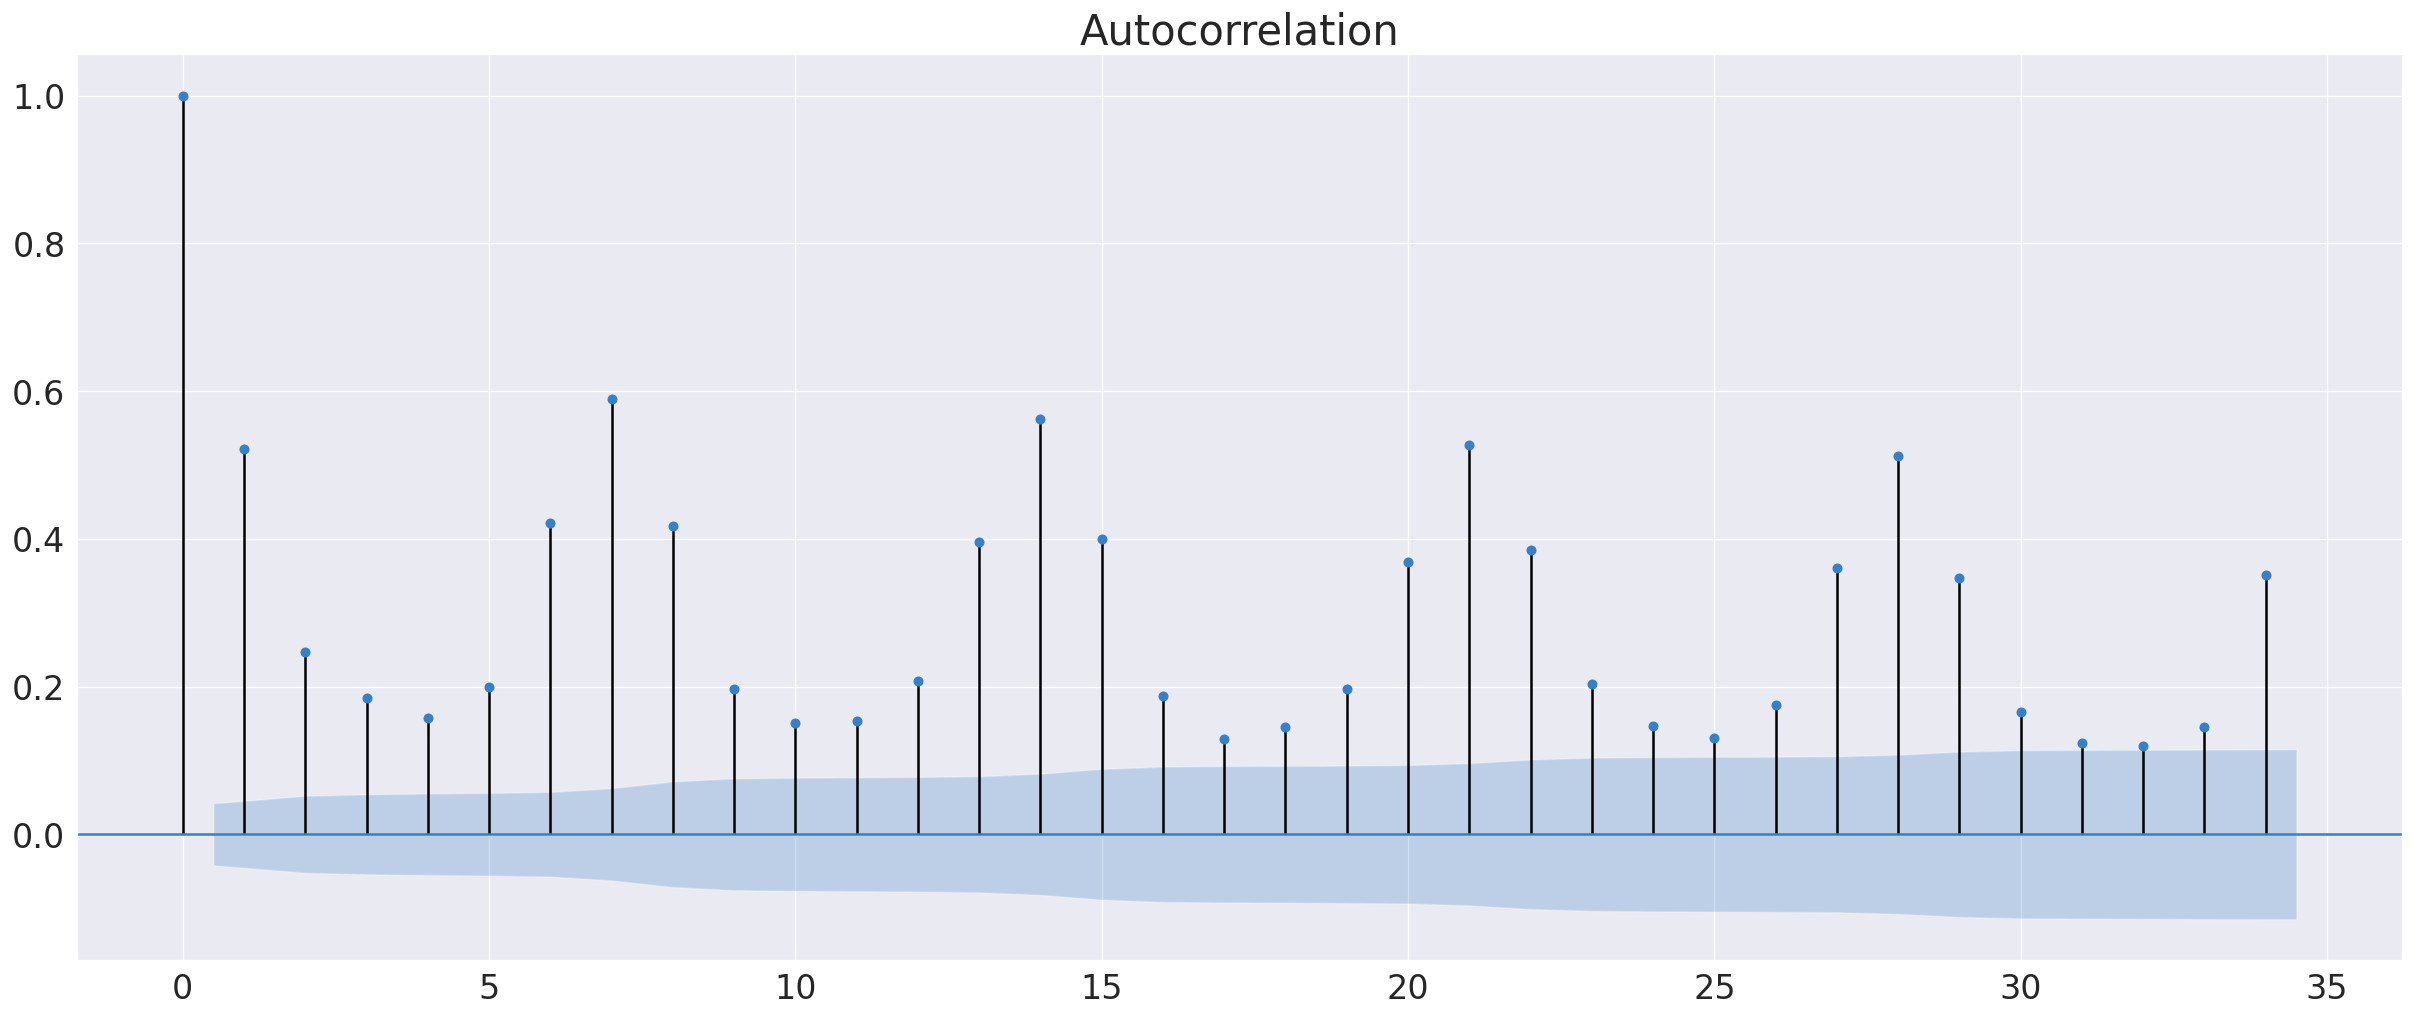

In [ ]:
# Use ACF plot to find q
plt.figure(figsize=(8,5))
plot_acf(ddf_6yr.duration)
plt.title('Autocorrelation',fontsize=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('ACF_q.jpg')

**Conclusion:** 

For p and q, we should initially take the order of AR and MA terms to be equal to as many lags that crosses the significance limit in the PACF/ACF plot.

We can find that in both plots, lag 1 are quite significant. Also, lag 2 in PACF plot and all lags in ACF are above significance line. As a result, we will initially set p=q=1, then make some adjustment according to the result.

## Set Up ARIMA Model


---
We will then begin modeling using our initialized p, d, and q, and enhance the model by modifying the hyperparameters.




### (1,0,1) Model

In [ ]:
# 1,0,1 ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ddf_6yr.duration, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:               duration   No. Observations:                 2189
Model:                     ARMA(1, 1)   Log Likelihood               -7029.909
Method:                       css-mle   S.D. of innovations              6.004
Date:                Sun, 01 May 2022   AIC                          14067.819
Time:                        21:16:26   BIC                          14090.583
Sample:                             0   HQIC                         14076.139
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.7075      0.256     88.813      0.000      22.206      23.209
ar.L1.duration     0.4485      0.042     10.657      0.000       0.366       0.531
ma.L1.duration     0.0991      0.049

The P Values of the AR1 and MA1 terms are highly significant (< 0.05),which is good. But p value for MA is very close to 0.05, maybe we can improve the performance of MA term by adding additional one lag, since we saw that many of them are significant in the ACF plot.

### (1,0,2) Model

In [ ]:
# 1,0,2 ARIMA Model

model2 = ARIMA(ddf_6yr.duration, order=(1,0,2))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:               duration   No. Observations:                 2189
Model:                     ARMA(1, 2)   Log Likelihood               -6901.177
Method:                       css-mle   S.D. of innovations              5.660
Date:                Sun, 01 May 2022   AIC                          13812.355
Time:                        21:16:27   BIC                          13840.811
Sample:                             0   HQIC                         13822.755
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.3925      1.337     16.752      0.000      19.773      25.012
ar.L1.duration     0.9929      0.003    342.332      0.000       0.987       0.999
ma.L1.duration    -0.5631      0.020

This summary shows that model2 does performs better than the original model, we have a smaller p value for MA term and overall lower AIC and BIC. But what about trying (2,0,2) model? Will the performance keep improving?

### (2,0,2) Model

In [ ]:
# 2,0,2 ARIMA Model

model3 = ARIMA(ddf_6yr.duration, order=(2,0,2))
model3_fit = model3.fit(disp=0)
print(model3_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:               duration   No. Observations:                 2189
Model:                     ARMA(2, 2)   Log Likelihood               -6901.131
Method:                       css-mle   S.D. of innovations              5.660
Date:                Sun, 01 May 2022   AIC                          13814.262
Time:                        21:16:28   BIC                          13848.409
Sample:                             0   HQIC                         13826.743
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.3924      1.336     16.756      0.000      19.773      25.012
ar.L1.duration     0.9770      0.052     18.665      0.000       0.874       1.080
ar.L2.duration     0.0158      0.052

Well, we find that the p value for L2 of AR term is not significant, and AIC/BIC is getting even larger than (1,0,2) mode. Till now, (1,0,2) is the best model of the three. So, we will keep the second model and continue checking its performance.

## Evaluate the Model


---

We will evaluate the model through the following three approaches:



*   Residuals
*   Actual vs. Fitted value
*   Accuracy Metrics



**Residuals**


---


Overall, the residual errors appear to be fine, with a near-zero mean, indicating that the model has a stable performance across time.

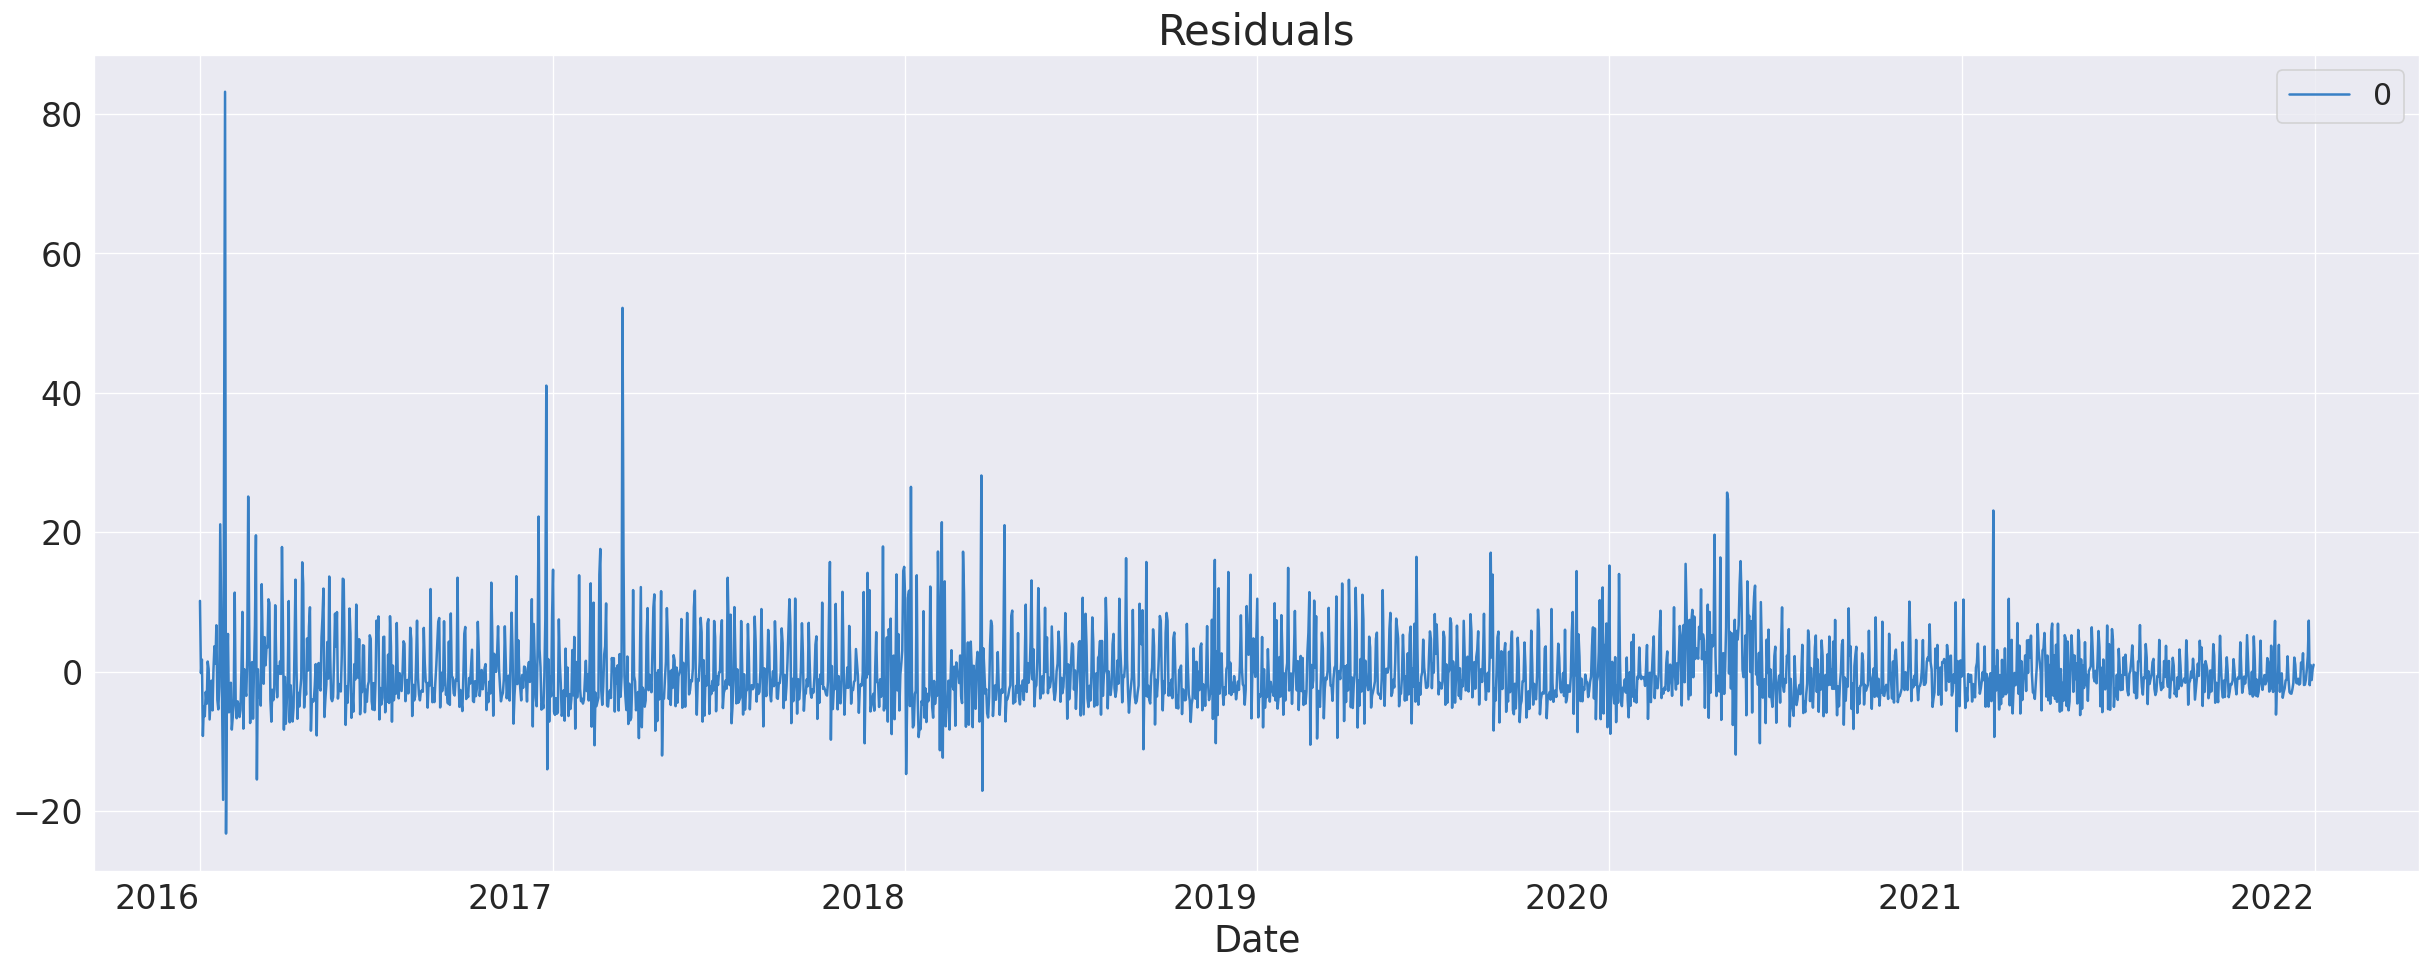

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model2_fit.resid)

residuals.plot()
plt.title('Residuals',fontsize=25)
plt.xticks(fontsize=20,rotation=0)
plt.yticks(fontsize=20)
plt.xlabel('Date',fontsize=22)
plt.legend(loc='best',fontsize=18)
plt.savefig('residual.jpg')

**Actual vs. Fitted value**


---

According to the plot， the values matches pretty well.

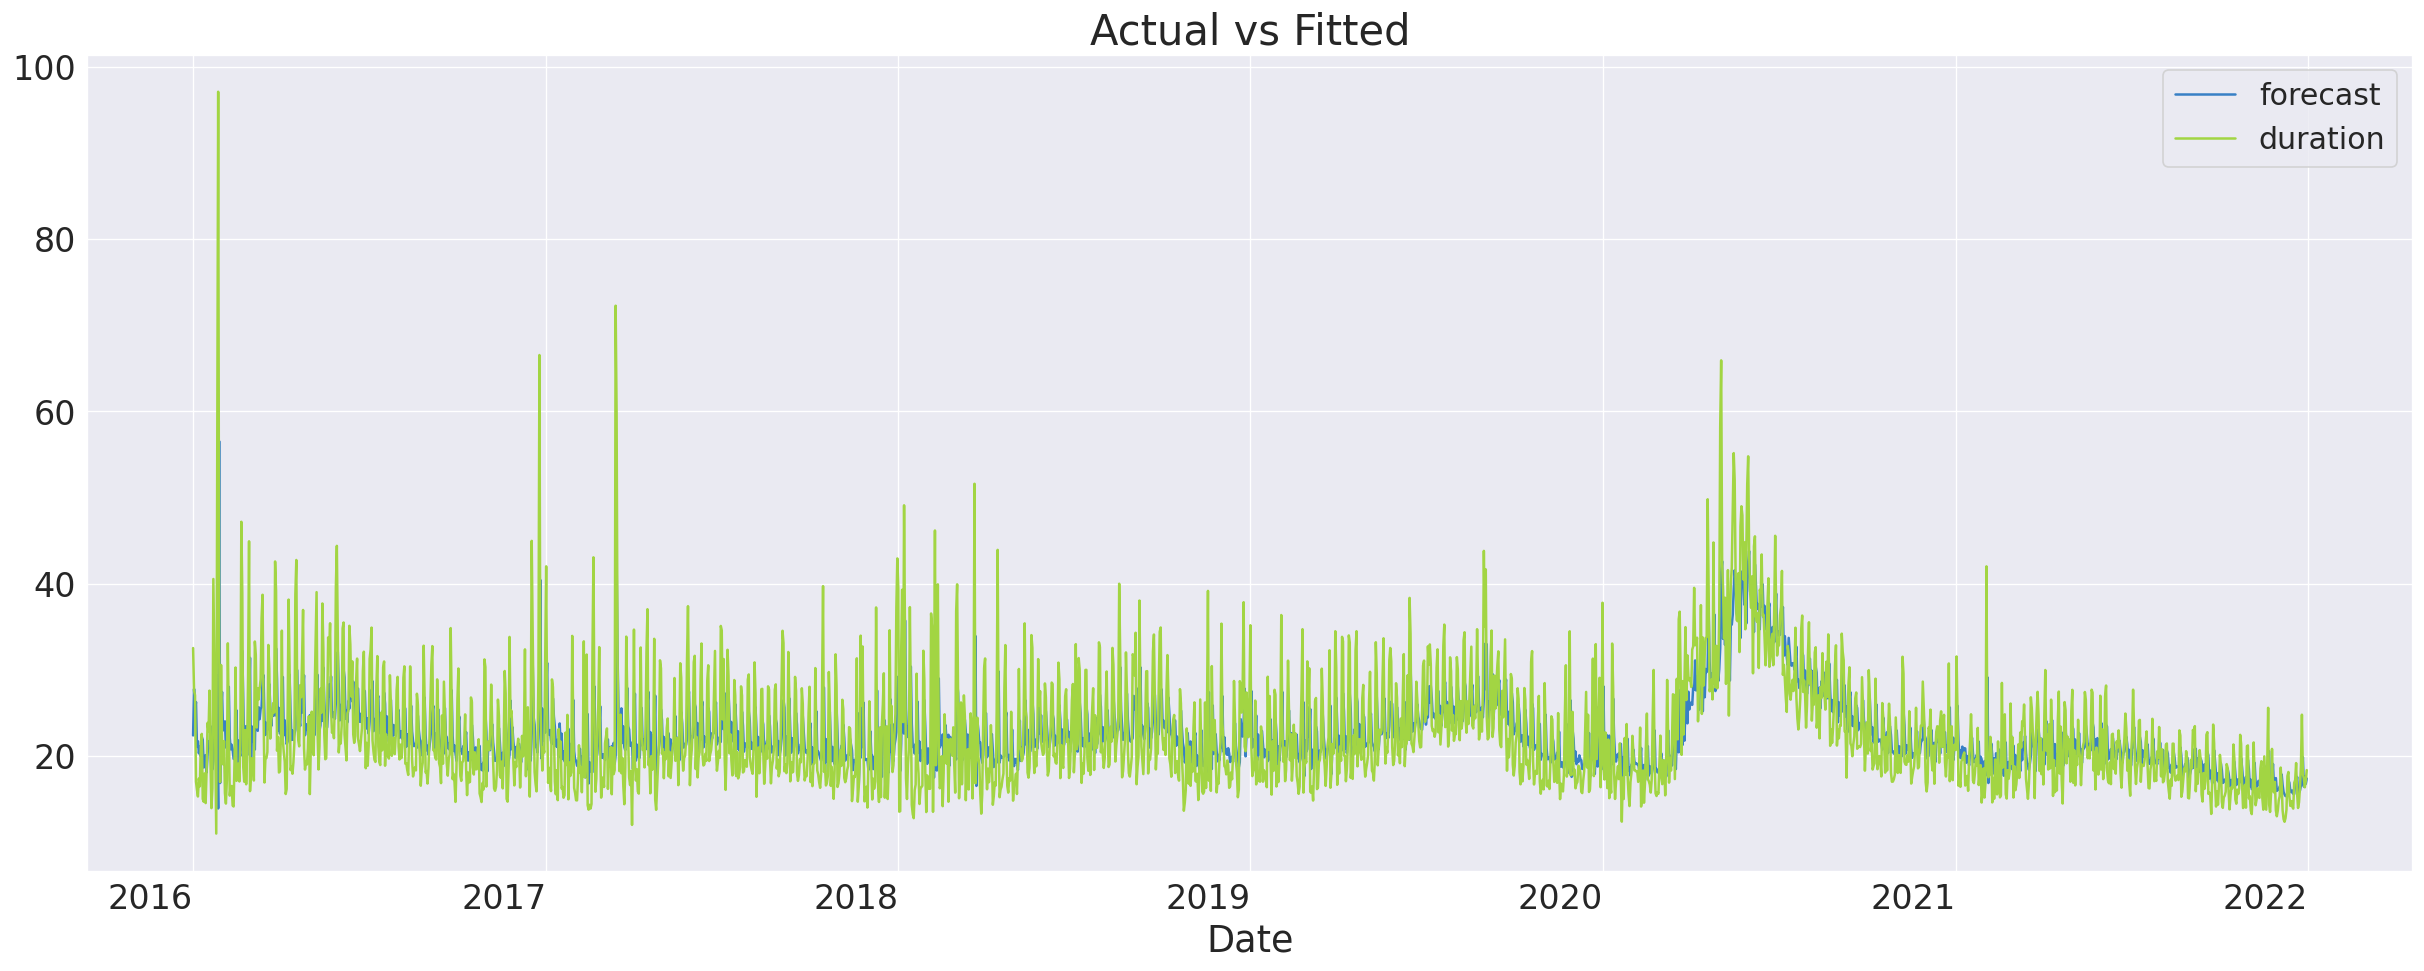

In [ ]:
# Actual vs Fitted value
model2_fit.plot_predict(dynamic=False)
plt.title('Actual vs Fitted',fontsize=25)
plt.xticks(fontsize=20,rotation=0)
plt.yticks(fontsize=20)
plt.xlabel('Date',fontsize=22)
plt.legend(loc='best',fontsize=18)
plt.savefig('Actual&fitted.jpg')

**Accuracy Metrics**


---


We seem to have a nice ARIMA model, but do we have some concrete evidence for evaluating the performance of our model?
Next, we are going to train the model and test the accuracy by using the following criteria:


*   Correlation between the Actual and the Forecast (corr)
*   Mean Absolute Percentage Error (MAPE)
*   Root Mean Squared Error (RMSE)

To better show the performance and improvement, we will compare the evaluation result of original (1,0,1) model and (1,0,2) model. 


In [ ]:
# Accuracy metrics of (1,0,1) model

# Create Training and Test
train = ddf_6yr.duration[:1640]
test = ddf_6yr.duration[1640:]

# Build Model
# model = ARIMA(train, order=(3,2,1))  
arima = ARIMA(train, order=(1, 0, 1))  
fitted = arima.fit(disp=0)  

# Forecast
fc, se, conf = fitted.forecast(549, alpha=0.05)  # 95% conf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'rmse':rmse,'corr':corr,})

forecast_accuracy(fc, test.values)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{'corr': 0.16149445802522971,
 'mape': 0.2558315941441338,
 'rmse': 5.577998275358468}

In [ ]:
# Accuracy metrics of (1,0,2) model

# Create Training and Test
train = ddf_6yr.duration[:1640]
test = ddf_6yr.duration[1640:]

# Build Model
# model = ARIMA(train, order=(3,2,1))  
arima = ARIMA(train, order=(1, 0, 2))  
fitted = arima.fit(disp=0)  

# Forecast
fc, se, conf = fitted.forecast(549, alpha=0.05)  # 95% conf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'rmse':rmse,'corr':corr,})

forecast_accuracy(fc, test.values)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{'corr': 0.6452634697978077,
 'mape': 0.4124545774769881,
 'rmse': 8.287972454333518}

**Conclusion:**

After comparing the two models, we found that (1,0,1) model has a lower *mape* value, which means the model is about 75% accurate in predicting the test set values, while the other one only has an accuracy around 59%. And the first model also has a lower *rmse* value. However, (1,0,2) model has a much higher *correlation* between actual and forecast values, which performs better than (1,0,1) model.

Overall, the results demonstrate that our model is not that perfect as it seems like, but still, Model 2 is barely satisfactory and acceptable.

#Obstacles Faced




*   Running with limited RAM

 Our analysis is devided into two parts: Classification Modeling and Time Series Analysis. Dataframes for the two process do not share a same structure. We need merge weather data for classification and import all the 6 years data for time series, so we need to seperately create the dataframes, which are both large. So the first challenge we met is how to optimize our procedure so that we can reduce running time and RAM usage. We figured out by using downcasting method, which transforms string type into catogory type, and float64 to float. In this way, the memory used for those dataframes decreased by over 80%

*   Big data running ML

  Due to the size of dataset we used for ML modelling, standard Sklearn ML libraries and package could not handle traditional machine learning models with big amount of data. We apply what we learned in class to use Spark ML, a powerful ML library that can handle "big" data.

*   Deciding interval of time series

 For time series, should we don't want to keep the original date_time unit of the specific trip time. But what is a suitable time slot? Hour, day, week or month? Smaller intervals may provide more accurate pattern, but we also want to reduce the data size and consider the readability of the plots.







#Potential Next Steps



*   Classification model vs. Linear regression model
 
 Next step, we could develop linear regression models to predict the ride usage time which is a continuous variable. But We tried out classification model first and then left without much RAM to train linear regression model.
 
*   SARIMA and SARIMAX model for time series

 In the time series analysis part, our ARIMA model is not that good in predicting future values. The reason may be that our data has a strong seasonality and ARIMA model doesn't deal with it very well. So, we may apply seasonal decomposition and introduce SARIMA/SARIMAX model for next step.

